<a href="https://colab.research.google.com/github/Berchie-Sam/Practice/blob/main/Pamen_GWL_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -V

Python 3.10.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mlflow

In [ ]:
import os
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, Dense, Dropout, Conv1D, Flatten, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import mlflow
import mlflow.sklearn
#import optuna
import seaborn as sns
import matplotlib.pyplot as plt



> a) Accessing TPU runtime



In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
# Set MLflow experiment name
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name='Pamen_DL_GWL_experiment')


In [ ]:
pamen_url = r"/content/drive/MyDrive/Datasets/Groundwater level (GWL) changes data/Pamen.csv"

In [ ]:
data = pd.read_csv(pamen_url)

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
data.head(10)

In [ ]:
data.tail(10)

In [ ]:
data = data.astype('float32')

In [ ]:
data.head()

In [ ]:
corr_matrix = data.corr()
print(corr_matrix)

In [ ]:
correlation_with_GWL = corr_matrix['GWL']
print('\nCorrelation with GWL:\n', correlation_with_GWL)

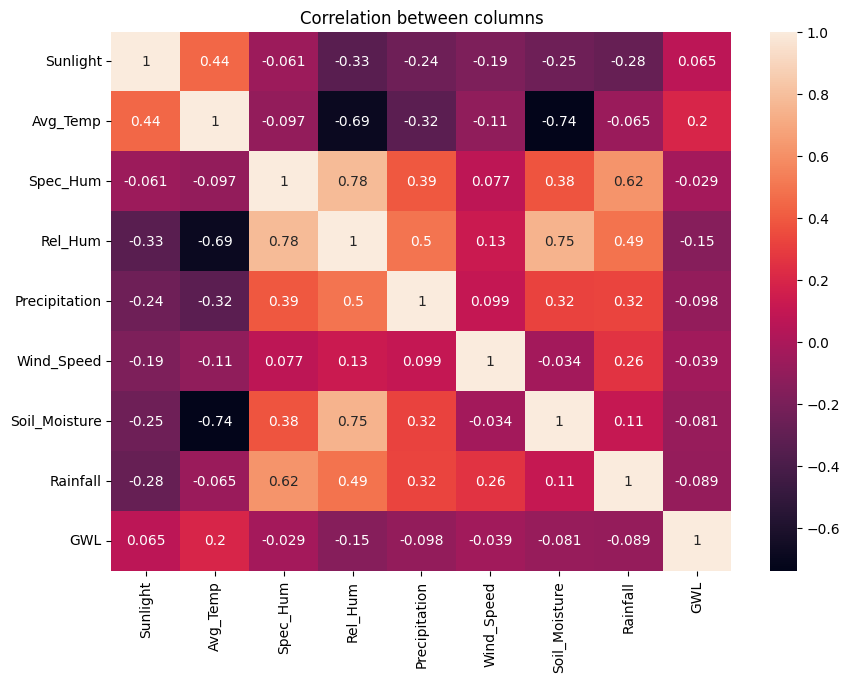

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between columns')
plt.show()

# Lighter color -> higher correlation value
# Darker color -> lower correlation value

In [ ]:
x = data.drop(columns = 'GWL')
x

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall
0,19.709999,27.260000,14.89,68.690002,0.00,1.49,0.52,379.600006
1,19.670000,27.219999,14.34,67.000000,0.00,1.40,0.52,401.299988
2,20.420000,27.650000,14.53,66.559998,0.00,1.73,0.52,405.500000
3,19.790001,27.520000,15.01,68.059998,0.00,1.23,0.52,397.899994
4,19.240000,27.790001,14.89,66.750000,0.00,1.33,0.52,384.899994
...,...,...,...,...,...,...,...,...
4013,20.870001,24.980000,8.42,45.619999,0.00,1.10,0.55,348.779999
4014,19.129999,26.270000,13.85,67.750000,0.02,1.27,0.55,372.940002
4015,19.320000,25.700001,11.66,59.439999,0.00,1.12,0.54,366.630005
4016,18.440001,25.830000,13.43,67.750000,0.01,1.37,0.54,367.589996


In [ ]:
y = data['GWL']
y

0       407.000000
1       407.000000
2       406.700012
3       406.899994
4       406.500000
           ...    
4013    443.899994
4014    443.899994
4015    444.500000
4016    444.399994
4017    444.399994
Name: GWL, Length: 4018, dtype: float32

In [ ]:
data.shape

(4018, 9)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) # Train (80%) and Test (20%)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size = 0.5, random_state = 42) # Validation (10%) and Test (10%)

In [ ]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('x_val', x_val.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

x_train (3214, 8)
x_test (1607, 8)
x_val (1607, 8)
y_train (3214,)
y_test (1607,)
y_val (1607,)


In [ ]:
# Scaling data into numpy arrays
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_train

array([[ 4.7818266e-02, -5.2952007e-03,  9.5399731e-01, ...,
        -1.4290426e+00,  1.8475393e+00, -2.3641244e-01],
       [-1.4521008e+00, -4.7886103e-02,  6.5006858e-01, ...,
         2.0458348e+00, -6.7202872e-01, -4.6342827e-02],
       [ 1.1904600e+00, -8.7537050e-01, -3.2291729e+00, ...,
        -5.0866961e-01,  3.3579883e-01, -5.9331350e+00],
       ...,
       [ 9.6098796e-02,  3.7194067e-01,  1.0203096e+00, ...,
         1.8955699e+00, -4.2007145e-01,  2.0874612e+00],
       [-5.7339311e-01, -6.9283658e-01, -5.6564850e-01, ...,
         2.2336657e+00,  8.3841562e-02, -3.6013767e-01],
       [-2.8692785e-01, -5.7723302e-01,  2.7982756e-01, ...,
        -9.7824764e-01,  7.1373355e-01,  1.1503630e-01]], dtype=float32)

In [ ]:
x_test

array([[-0.40280157, -0.8449476 ,  0.51191896, ...,  1.1818112 ,
         1.0916691 ,  0.50503904],
       [ 1.0488366 ,  1.0838203 ,  0.6500686 , ...,  1.1254619 ,
        -0.92398524,  0.38400334],
       [-0.47683176, -0.8023567 ,  0.37929544, ..., -1.2224282 ,
         0.9656908 ,  0.01641451],
       ...,
       [ 0.47268787,  1.1081575 , -0.32803097, ..., -0.28327218,
        -0.798007  , -0.38703603],
       [ 0.7044347 , -0.03571694,  0.74953645, ..., -1.1660789 ,
         2.099496  , -0.6237256 ],
       [ 0.86215144, -0.12089992,  0.7826921 , ...,  0.48683596,
         0.46177706,  0.9577991 ]], dtype=float32)

In [ ]:
x_val

array([[ 0.06069279,  0.74917537, -1.2729743 , ..., -0.92189837,
        -1.0499635 , -2.1622174 ],
       [ 1.171148  ,  0.6335718 ,  0.6500686 , ...,  0.5619684 ,
        -0.04213669, -0.37179336],
       [ 0.05103644, -1.3012806 ,  0.34613878, ...,  0.16752274,
         1.595582  ,  0.14193465],
       ...,
       [-1.2267911 , -1.173508  ,  0.00905444, ...,  2.4590635 ,
         0.46177706,  1.334354  ],
       [-0.9338886 , -0.72934407,  0.9539973 , ..., -0.24570596,
         0.9656908 ,  1.5584933 ],
       [ 0.41153222, -0.425122  ,  1.0534652 , ...,  0.28022137,
         1.4696038 ,  0.8860756 ]], dtype=float32)

In [ ]:
print(x_train.shape[1])

epochs = 2000
batch_size = 50
patience = 100

8


### 1. Feed-Forward Neural Network

In [ ]:
with strategy.scope():
  # Start MLflow run
  with mlflow.start_run():

      # Log parameters
      mlflow.set_tag("programmer", "Berchie")

      mlflow.set_tag("model_type", "feedforward_neural_network")
      mlflow.set_tag("tensorflow_version", tf.__version__)
      mlflow.set_tag("experiment", "Pamen")
      mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Pamen.csv")
      mlflow.log_param('epochs', epochs)
      mlflow.log_param('batch_size', batch_size)

      # Feed forward neural network model architecture
      ffn_model = Sequential()
      ffn_model.add(Input(shape=(x_train.shape[1],)))
      ffn_model.add(Dense(1000, activation='relu'))
      ffn_model.add(Dense(500, activation='relu'))
      ffn_model.add(Dense(250, activation='linear'))
      ffn_model.add(Dense(1, activation='linear'))

      # Log the model architecture using mlflow.tensorflow
      mlflow.tensorflow.log_model(ffn_model, 'pamen_ffn_model')
      ffn_model.summary()

      # Define your model
      ffn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

      earlyStop = EarlyStopping(monitor='val_loss',
                              mode='min',
                              patience=patience)


      # Train the model
      history = ffn_model.fit(x_train, y_train,
                              epochs=epochs,
                              callbacks=[earlyStop],
                              batch_size=batch_size,
                              validation_data=(x_val, y_val),
                              verbose=1)

      # Log final metrics
      mlflow.log_metric("pamen_final_training_loss", history.history['loss'][-1])
      mlflow.log_metric("pamen_final_validation_loss", history.history['val_loss'][-1])

      # Predictions
      train_preds = ffn_model.predict(x_train)
      val_preds = ffn_model.predict(x_val)
      test_preds = ffn_model.predict(x_test)

      # Evaluation on test set
      ffn_results = ffn_model.evaluate(x_test, y_test)

      # MAE
      train_mae = mean_absolute_error(y_train, train_preds)
      val_mae = mean_absolute_error(y_val, val_preds)
      test_mae = ffn_results[1]

      # MSE
      train_mse = mean_squared_error(y_train, train_preds)
      val_mse = mean_squared_error(y_val, val_preds)
      test_mse = ffn_results[0]

      # RMSE
      train_rmse = np.sqrt(train_mse)
      val_rmse = np.sqrt(val_mse)
      test_rmse = np.sqrt(test_mse)

      # R-Square
      train_r2 = r2_score(y_train, train_preds)
      val_r2 = r2_score(y_val, val_preds)
      test_r2 = r2_score(y_test, test_preds)

      # MAPE
      train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
      val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
      test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

      # AIC calculation for the feed-forward neural network
      n_samples = len(y_train)
      log_likelihood = -0.5 * n_samples * np.log(2 * np.pi * train_mse) - 0.5 * n_samples

      # Number of parameters in the model
      n_params = sum([np.prod(w.shape) for w in ffn_model.get_weights()])

      # Calculate AIC
      aic_ffn = -2 * log_likelihood + 2 * n_params

      # Log AIC as a metric
      mlflow.log_metric("pamen_aic_ffn", aic_ffn)

      # Logging metrics
      mlflow.log_metric("pamen_train_mae", train_mae)
      mlflow.log_metric("pamen_val_mae", val_mae)
      mlflow.log_metric("pamen_test_mae", test_mae)

      mlflow.log_metric("pamen_train_mse", train_mse)
      mlflow.log_metric("pamen_val_mse", val_mse)
      mlflow.log_metric("pamen_test_mse", test_mse)

      mlflow.log_metric("pamen_train_rmse", train_rmse)
      mlflow.log_metric("pamen_val_rmse", val_rmse)
      mlflow.log_metric("pamen_test_rmse", test_rmse)

      mlflow.log_metric("pamen_train_r2", train_r2)
      mlflow.log_metric("pamen_val_r2", val_r2)
      mlflow.log_metric("pamen_test_r2", test_r2)

      mlflow.log_metric("pamen_train_mape", train_mape)
      mlflow.log_metric("pamen_val_mape", val_mape)
      mlflow.log_metric("pamen_test_mape", test_mape)

      # Plot and save training/validation loss
      plt.plot(history.history['loss'], label='Training loss')
      plt.plot(history.history['val_loss'], label='Validation loss')
      plt.title('FFNN Training and Validation Loss (Pamen)')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

      #Directory to save the plot
      plot_directory = "D:\\RGT\\Code\\Practice\\Deep Learning for GWL Changes\\Artifacts"
      os.makedirs(plot_directory, exist_ok=True)

      loss_plot_path = os.path.join(plot_directory, "pamen_ffn_loss_plot.png")
      plt.savefig(loss_plot_path)
      mlflow.log_artifact(loss_plot_path)

      # Log scatter plots
      fig, axes = plt.subplots(1, 3)

      # Training Results
      axes[0].scatter(x=y_train, y=train_preds)
      axes[0].set_xlabel("Actual", fontsize=10)
      axes[0].set_ylabel("Predicted", fontsize=10)
      axes[0].set_title("Training")

      x = np.linspace(*axes[0].get_xlim())
      axes[0].plot(x, x, color='red')

      # Validation Results
      axes[1].scatter(x=y_val, y=val_preds)
      axes[1].set_xlabel("Actual", fontsize=10)
      axes[1].set_ylabel("Predicted", fontsize=10)
      axes[1].set_title("Validation")

      x = np.linspace(*axes[1].get_xlim())
      axes[1].plot(x, x, color='orange')

      # Testing Results
      test_preds = ffn_model.predict(x_test)
      axes[2].scatter(x=y_test, y=test_preds)
      axes[2].set_xlabel("Actual", fontsize=10)
      axes[2].set_ylabel("Predicted", fontsize=10)
      axes[2].set_title("Testing")

      x = np.linspace(*axes[2].get_xlim())
      axes[2].plot(x, x, color='yellow')

      # Tight layout
      fig.tight_layout()
      plt.show()

      # Save scatter plot
      scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ffn_scatter_plot.png'
      plt.savefig(scatter_plot_path)
      mlflow.log_artifact(scatter_plot_path)


      # Save the model as a TensorFlow SavedModel (optional)
      saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ffn_saved_model'
      ffn_model.save(saved_model_path)

      # Log the SavedModel as an artifact
      mlflow.log_artifact(saved_model_path)

      mlflow.end_run()


2024/02/01 13:02:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
WARNI [tensorflow] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 635001 (2.42 MB)
Trainable params: 635001 (2.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Epoch 1/2000
65/65 [==============================] - 1s 11ms/step - loss: 24960.4297 - mae: 110.8003 - val_loss: 4677.3320 - val_mae: 54.4463
Epoch 2/2000
65/65 [==============================] - 1s 9ms/step - loss: 3810.8142 - mae: 48.3358 - val_loss: 4941.5474 - val_mae: 60.0222
Epoch 3/2000
65/65 [==============================] - 1s 9ms/step - loss: 2355.4495 - mae: 38.0219 - val_loss: 1800.4880 - val_mae: 32.1216
Epoch 4/2000
65/65 [==============================] - 1s 8ms/step - loss: 1642.0347 - mae: 32.0142 - val_loss: 1089.8403 - val_mae: 25.1924
Epoch 5/2000
65/65 [==============================] - 1s 9ms/step - loss: 1353.5149 - mae: 28.9053 - val_loss: 1095.0802 - val_mae: 23.2036
Epoch 6/2000
65/65 [==============================] - 1s 9ms/step - loss: 1260.0378 - mae: 27.5410 - val_loss: 1349.0455 - val_mae: 27.8941
Epoch 7/2000
65/65 [==============================] - 1s 9ms/step - loss: 1180.7526 - mae: 26.9431 - val_loss: 1141.1339 - val_mae: 28.7470
Epoch 8/2000
65/6

KeyboardInterrupt: 

### 2. Convolutional Neural Network

In [ ]:
# Reshape data for CNN
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train_cnn.shape)

x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(x_val_cnn.shape)

x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test_cnn.shape)

(3214, 8, 1)
(1607, 8, 1)
(1607, 8, 1)



2024/01/28 07:53:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpuocxg14w\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpuocxg14w\model\data\model\assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 1000)           4000      
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 1000)           0         
 D)                                                              
                                                                 
 dense_12 (Dense)            (None, 3, 500)            500500    
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense_13 (Dense)            (None, 250)               375250    
                                                                 
 dense_14 (Dense)            (None, 1)                 251       
                                                      

65/65 [==============================] - 1s 16ms/step - loss: 607.4994 - mae: 17.8971 - val_loss: 574.0103 - val_mae: 18.4315
Epoch 51/2000
65/65 [==============================] - 1s 16ms/step - loss: 583.8661 - mae: 17.3324 - val_loss: 558.1261 - val_mae: 17.8935
Epoch 52/2000
65/65 [==============================] - 1s 16ms/step - loss: 580.9074 - mae: 17.4584 - val_loss: 679.1199 - val_mae: 16.9377
Epoch 53/2000
65/65 [==============================] - 1s 16ms/step - loss: 604.1806 - mae: 17.6794 - val_loss: 584.3325 - val_mae: 18.9044
Epoch 54/2000
65/65 [==============================] - 1s 16ms/step - loss: 605.0070 - mae: 17.8990 - val_loss: 542.3127 - val_mae: 15.6109
Epoch 55/2000
65/65 [==============================] - 1s 16ms/step - loss: 593.7824 - mae: 17.5549 - val_loss: 603.1969 - val_mae: 16.0105
Epoch 56/2000
65/65 [==============================] - 1s 16ms/step - loss: 595.9401 - mae: 17.6998 - val_loss: 546.0367 - val_mae: 16.0501
Epoch 57/2000
65/65 [=============

65/65 [==============================] - 1s 16ms/step - loss: 606.4075 - mae: 17.8424 - val_loss: 569.0531 - val_mae: 18.3242
Epoch 109/2000
65/65 [==============================] - 1s 16ms/step - loss: 588.4022 - mae: 17.6592 - val_loss: 715.6584 - val_mae: 17.9520
Epoch 110/2000
65/65 [==============================] - 1s 16ms/step - loss: 640.2750 - mae: 18.6444 - val_loss: 651.2112 - val_mae: 20.9296
Epoch 111/2000
65/65 [==============================] - 1s 16ms/step - loss: 564.9931 - mae: 17.0175 - val_loss: 532.3593 - val_mae: 16.3032
Epoch 112/2000
65/65 [==============================] - 1s 16ms/step - loss: 587.0323 - mae: 17.5915 - val_loss: 715.6939 - val_mae: 17.9465
Epoch 113/2000
65/65 [==============================] - 1s 16ms/step - loss: 584.3138 - mae: 17.5617 - val_loss: 538.6924 - val_mae: 16.5271
Epoch 114/2000
65/65 [==============================] - 1s 16ms/step - loss: 564.0979 - mae: 16.8894 - val_loss: 570.6451 - val_mae: 18.6275
Epoch 115/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 565.2468 - mae: 17.2489 - val_loss: 744.5230 - val_mae: 23.4406
Epoch 167/2000
65/65 [==============================] - 1s 16ms/step - loss: 595.4670 - mae: 17.8052 - val_loss: 568.8048 - val_mae: 15.5668
Epoch 168/2000
65/65 [==============================] - 1s 16ms/step - loss: 570.0297 - mae: 17.3185 - val_loss: 531.1176 - val_mae: 17.1366
Epoch 169/2000
65/65 [==============================] - 1s 16ms/step - loss: 568.3090 - mae: 17.3050 - val_loss: 529.8242 - val_mae: 16.0192
Epoch 170/2000
65/65 [==============================] - 1s 16ms/step - loss: 574.1630 - mae: 17.3731 - val_loss: 534.6160 - val_mae: 17.0879
Epoch 171/2000
65/65 [==============================] - 1s 16ms/step - loss: 555.8303 - mae: 17.1053 - val_loss: 975.1843 - val_mae: 28.1989
Epoch 172/2000
65/65 [==============================] - 1s 16ms/step - loss: 633.1976 - mae: 18.5839 - val_loss: 539.4143 - val_mae: 15.7396
Epoch 173/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 564.6588 - mae: 17.3584 - val_loss: 731.0488 - val_mae: 23.2636
Epoch 225/2000
65/65 [==============================] - 1s 16ms/step - loss: 555.6677 - mae: 17.0932 - val_loss: 542.9894 - val_mae: 15.8225
Epoch 226/2000
65/65 [==============================] - 1s 16ms/step - loss: 535.7600 - mae: 16.5394 - val_loss: 730.2556 - val_mae: 23.2361
Epoch 227/2000
65/65 [==============================] - 1s 16ms/step - loss: 556.7010 - mae: 17.2853 - val_loss: 495.9379 - val_mae: 15.5915
Epoch 228/2000
65/65 [==============================] - 1s 16ms/step - loss: 545.4852 - mae: 16.8690 - val_loss: 732.5405 - val_mae: 23.2260
Epoch 229/2000
65/65 [==============================] - 1s 16ms/step - loss: 556.7340 - mae: 17.1293 - val_loss: 545.8012 - val_mae: 18.2769
Epoch 230/2000
65/65 [==============================] - 1s 16ms/step - loss: 564.0355 - mae: 17.3335 - val_loss: 583.9722 - val_mae: 19.6507
Epoch 231/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 512.0571 - mae: 16.4854 - val_loss: 481.1845 - val_mae: 14.8091
Epoch 283/2000
65/65 [==============================] - 1s 16ms/step - loss: 514.6720 - mae: 16.3501 - val_loss: 480.4758 - val_mae: 15.1941
Epoch 284/2000
65/65 [==============================] - 1s 16ms/step - loss: 529.8880 - mae: 16.7073 - val_loss: 495.5245 - val_mae: 15.0608
Epoch 285/2000
65/65 [==============================] - 1s 16ms/step - loss: 520.5365 - mae: 16.5769 - val_loss: 635.4238 - val_mae: 16.8919
Epoch 286/2000
65/65 [==============================] - 1s 16ms/step - loss: 520.1582 - mae: 16.4237 - val_loss: 484.5544 - val_mae: 14.8954
Epoch 287/2000
65/65 [==============================] - 1s 16ms/step - loss: 516.1102 - mae: 16.3529 - val_loss: 505.1394 - val_mae: 15.0439
Epoch 288/2000
65/65 [==============================] - 1s 17ms/step - loss: 533.8096 - mae: 16.8215 - val_loss: 493.0765 - val_mae: 15.1871
Epoch 289/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 487.8008 - mae: 15.8726 - val_loss: 490.1458 - val_mae: 15.0520
Epoch 341/2000
65/65 [==============================] - 1s 16ms/step - loss: 511.5815 - mae: 16.2604 - val_loss: 469.3431 - val_mae: 16.2543
Epoch 342/2000
65/65 [==============================] - 1s 16ms/step - loss: 518.8276 - mae: 16.6968 - val_loss: 486.0637 - val_mae: 15.0609
Epoch 343/2000
65/65 [==============================] - 1s 16ms/step - loss: 507.7032 - mae: 16.3254 - val_loss: 559.2054 - val_mae: 16.0276
Epoch 344/2000
65/65 [==============================] - 1s 16ms/step - loss: 497.1167 - mae: 16.1306 - val_loss: 481.2727 - val_mae: 15.3349
Epoch 345/2000
65/65 [==============================] - 1s 16ms/step - loss: 502.0579 - mae: 16.0850 - val_loss: 478.4462 - val_mae: 15.0565
Epoch 346/2000
65/65 [==============================] - 1s 16ms/step - loss: 506.3589 - mae: 16.2999 - val_loss: 460.5675 - val_mae: 15.0259
Epoch 347/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 481.0769 - mae: 15.7614 - val_loss: 461.0317 - val_mae: 15.9095
Epoch 399/2000
65/65 [==============================] - 1s 16ms/step - loss: 484.7405 - mae: 15.9502 - val_loss: 454.2823 - val_mae: 15.7521
Epoch 400/2000
65/65 [==============================] - 1s 16ms/step - loss: 492.5287 - mae: 16.1245 - val_loss: 624.2127 - val_mae: 17.1528
Epoch 401/2000
65/65 [==============================] - 1s 16ms/step - loss: 494.0845 - mae: 15.9987 - val_loss: 536.8242 - val_mae: 15.5658
Epoch 402/2000
65/65 [==============================] - 1s 16ms/step - loss: 519.7295 - mae: 16.7397 - val_loss: 504.3900 - val_mae: 17.8333
Epoch 403/2000
65/65 [==============================] - 1s 16ms/step - loss: 499.1804 - mae: 16.2737 - val_loss: 469.4086 - val_mae: 14.7826
Epoch 404/2000
65/65 [==============================] - 1s 16ms/step - loss: 508.8078 - mae: 16.4767 - val_loss: 458.9084 - val_mae: 16.1626
Epoch 405/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 463.7407 - mae: 15.5399 - val_loss: 462.2602 - val_mae: 15.1552
Epoch 457/2000
65/65 [==============================] - 1s 17ms/step - loss: 483.8781 - mae: 16.0007 - val_loss: 428.8206 - val_mae: 14.6466
Epoch 458/2000
65/65 [==============================] - 1s 16ms/step - loss: 457.4445 - mae: 15.3981 - val_loss: 482.1742 - val_mae: 15.0667
Epoch 459/2000
65/65 [==============================] - 1s 16ms/step - loss: 493.8950 - mae: 16.2173 - val_loss: 495.0592 - val_mae: 17.5176
Epoch 460/2000
65/65 [==============================] - 1s 16ms/step - loss: 475.8724 - mae: 15.9308 - val_loss: 528.8459 - val_mae: 18.7590
Epoch 461/2000
65/65 [==============================] - 1s 16ms/step - loss: 484.1087 - mae: 15.9737 - val_loss: 427.5955 - val_mae: 14.7645
Epoch 462/2000
65/65 [==============================] - 1s 16ms/step - loss: 461.9359 - mae: 15.4443 - val_loss: 476.2342 - val_mae: 17.1482
Epoch 463/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 466.7236 - mae: 15.7713 - val_loss: 494.8701 - val_mae: 17.8211
Epoch 515/2000
65/65 [==============================] - 1s 16ms/step - loss: 475.5198 - mae: 15.9540 - val_loss: 414.3867 - val_mae: 14.1735
Epoch 516/2000
65/65 [==============================] - 1s 16ms/step - loss: 460.0453 - mae: 15.5468 - val_loss: 458.2439 - val_mae: 16.6186
Epoch 517/2000
65/65 [==============================] - 1s 16ms/step - loss: 441.5937 - mae: 15.1293 - val_loss: 419.1816 - val_mae: 14.8755
Epoch 518/2000
65/65 [==============================] - 1s 16ms/step - loss: 455.1448 - mae: 15.4910 - val_loss: 421.3779 - val_mae: 15.2156
Epoch 519/2000
65/65 [==============================] - 1s 16ms/step - loss: 458.0049 - mae: 15.5020 - val_loss: 437.0184 - val_mae: 15.7054
Epoch 520/2000
65/65 [==============================] - 1s 16ms/step - loss: 450.2035 - mae: 15.4741 - val_loss: 435.8353 - val_mae: 15.6581
Epoch 521/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 434.1229 - mae: 14.9869 - val_loss: 410.1618 - val_mae: 14.2437
Epoch 573/2000
65/65 [==============================] - 1s 16ms/step - loss: 457.0540 - mae: 15.7296 - val_loss: 410.8166 - val_mae: 14.4275
Epoch 574/2000
65/65 [==============================] - 1s 16ms/step - loss: 442.3718 - mae: 15.2795 - val_loss: 428.8747 - val_mae: 14.4745
Epoch 575/2000
65/65 [==============================] - 1s 16ms/step - loss: 477.0991 - mae: 16.0075 - val_loss: 568.7520 - val_mae: 19.8351
Epoch 576/2000
65/65 [==============================] - 1s 16ms/step - loss: 482.6334 - mae: 16.1497 - val_loss: 430.6702 - val_mae: 15.7560
Epoch 577/2000
65/65 [==============================] - 1s 16ms/step - loss: 446.4955 - mae: 15.4274 - val_loss: 470.2768 - val_mae: 15.1096
Epoch 578/2000
65/65 [==============================] - 1s 16ms/step - loss: 518.9554 - mae: 17.0626 - val_loss: 414.9728 - val_mae: 14.3644
Epoch 579/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 418.0022 - mae: 14.7340 - val_loss: 386.4393 - val_mae: 13.9291
Epoch 631/2000
65/65 [==============================] - 1s 16ms/step - loss: 430.3108 - mae: 15.0558 - val_loss: 399.0729 - val_mae: 14.6909
Epoch 632/2000
65/65 [==============================] - 1s 16ms/step - loss: 425.7306 - mae: 14.9475 - val_loss: 382.3839 - val_mae: 14.0315
Epoch 633/2000
65/65 [==============================] - 1s 16ms/step - loss: 419.0239 - mae: 14.8159 - val_loss: 394.2953 - val_mae: 14.8330
Epoch 634/2000
65/65 [==============================] - 1s 16ms/step - loss: 452.8482 - mae: 15.6126 - val_loss: 496.2778 - val_mae: 17.9176
Epoch 635/2000
65/65 [==============================] - 1s 16ms/step - loss: 442.4468 - mae: 15.4214 - val_loss: 399.8502 - val_mae: 15.1253
Epoch 636/2000
65/65 [==============================] - 1s 16ms/step - loss: 462.8870 - mae: 16.0048 - val_loss: 420.6424 - val_mae: 15.7073
Epoch 637/2000
65/65 [======

65/65 [==============================] - 1s 14ms/step - loss: 420.8395 - mae: 15.0900 - val_loss: 613.8620 - val_mae: 18.5451
Epoch 689/2000
65/65 [==============================] - 1s 15ms/step - loss: 421.0443 - mae: 14.9743 - val_loss: 401.7432 - val_mae: 15.2908
Epoch 690/2000
65/65 [==============================] - 1s 15ms/step - loss: 433.0017 - mae: 15.4313 - val_loss: 395.0868 - val_mae: 15.0683
Epoch 691/2000
65/65 [==============================] - 1s 14ms/step - loss: 402.9648 - mae: 14.4421 - val_loss: 429.8211 - val_mae: 16.4062
Epoch 692/2000
65/65 [==============================] - 1s 14ms/step - loss: 408.9081 - mae: 14.8831 - val_loss: 373.4545 - val_mae: 14.2086
Epoch 693/2000
65/65 [==============================] - 1s 14ms/step - loss: 415.5974 - mae: 14.8407 - val_loss: 394.6701 - val_mae: 15.0540
Epoch 694/2000
65/65 [==============================] - 1s 14ms/step - loss: 411.9152 - mae: 14.9410 - val_loss: 370.4886 - val_mae: 13.6171
Epoch 695/2000
65/65 [======

65/65 [==============================] - 1s 15ms/step - loss: 383.0724 - mae: 14.1521 - val_loss: 392.1161 - val_mae: 15.5397
Epoch 747/2000
65/65 [==============================] - 1s 14ms/step - loss: 415.5051 - mae: 15.1136 - val_loss: 376.3343 - val_mae: 14.1007
Epoch 748/2000
65/65 [==============================] - 1s 15ms/step - loss: 441.5836 - mae: 15.6674 - val_loss: 360.8661 - val_mae: 13.2871
Epoch 749/2000
65/65 [==============================] - 1s 14ms/step - loss: 457.7677 - mae: 16.0944 - val_loss: 367.9810 - val_mae: 14.4301
Epoch 750/2000
65/65 [==============================] - 1s 14ms/step - loss: 408.9980 - mae: 14.9912 - val_loss: 397.9477 - val_mae: 13.9674
Epoch 751/2000
65/65 [==============================] - 1s 15ms/step - loss: 388.2374 - mae: 14.2843 - val_loss: 345.6814 - val_mae: 12.9285
Epoch 752/2000
65/65 [==============================] - 1s 14ms/step - loss: 377.2115 - mae: 14.0417 - val_loss: 352.3764 - val_mae: 13.4170
Epoch 753/2000
65/65 [======

65/65 [==============================] - 1s 15ms/step - loss: 388.8350 - mae: 14.5085 - val_loss: 373.0053 - val_mae: 14.3233
Epoch 805/2000
65/65 [==============================] - 1s 15ms/step - loss: 367.9536 - mae: 14.0031 - val_loss: 344.4344 - val_mae: 13.1995
Epoch 806/2000
65/65 [==============================] - 1s 14ms/step - loss: 388.2789 - mae: 14.6149 - val_loss: 331.7612 - val_mae: 13.0654
Epoch 807/2000
65/65 [==============================] - 1s 15ms/step - loss: 361.3679 - mae: 13.7789 - val_loss: 333.5042 - val_mae: 13.1885
Epoch 808/2000
65/65 [==============================] - 1s 14ms/step - loss: 368.7130 - mae: 14.0112 - val_loss: 330.4695 - val_mae: 13.1373
Epoch 809/2000
65/65 [==============================] - 1s 14ms/step - loss: 365.7195 - mae: 13.9605 - val_loss: 381.9848 - val_mae: 15.5608
Epoch 810/2000
65/65 [==============================] - 1s 14ms/step - loss: 362.7291 - mae: 13.9277 - val_loss: 345.9121 - val_mae: 14.1522
Epoch 811/2000
65/65 [======

65/65 [==============================] - 1s 15ms/step - loss: 351.6140 - mae: 13.7496 - val_loss: 347.9689 - val_mae: 13.0905
Epoch 863/2000
65/65 [==============================] - 1s 14ms/step - loss: 349.0019 - mae: 13.7198 - val_loss: 308.4575 - val_mae: 12.4382
Epoch 864/2000
65/65 [==============================] - 1s 15ms/step - loss: 349.4383 - mae: 13.6869 - val_loss: 320.4511 - val_mae: 13.1143
Epoch 865/2000
65/65 [==============================] - 1s 16ms/step - loss: 352.4822 - mae: 13.7003 - val_loss: 310.7950 - val_mae: 12.9990
Epoch 866/2000
65/65 [==============================] - 1s 14ms/step - loss: 349.1489 - mae: 13.7050 - val_loss: 336.5732 - val_mae: 13.5716
Epoch 867/2000
65/65 [==============================] - 1s 15ms/step - loss: 353.1257 - mae: 13.7820 - val_loss: 299.8325 - val_mae: 12.5129
Epoch 868/2000
65/65 [==============================] - 1s 15ms/step - loss: 340.3200 - mae: 13.4130 - val_loss: 383.7790 - val_mae: 15.6733
Epoch 869/2000
65/65 [======

65/65 [==============================] - 1s 12ms/step - loss: 344.1353 - mae: 13.7923 - val_loss: 287.7921 - val_mae: 12.1736
Epoch 921/2000
65/65 [==============================] - 1s 13ms/step - loss: 321.9981 - mae: 13.0621 - val_loss: 297.9652 - val_mae: 13.1275
Epoch 922/2000
65/65 [==============================] - 1s 14ms/step - loss: 340.7071 - mae: 13.7036 - val_loss: 288.9486 - val_mae: 12.4538
Epoch 923/2000
65/65 [==============================] - 1s 13ms/step - loss: 334.6328 - mae: 13.4436 - val_loss: 327.3139 - val_mae: 14.0334
Epoch 924/2000
65/65 [==============================] - 1s 13ms/step - loss: 331.8659 - mae: 13.3646 - val_loss: 385.5468 - val_mae: 15.9253
Epoch 925/2000
65/65 [==============================] - 1s 13ms/step - loss: 332.9141 - mae: 13.4071 - val_loss: 283.3078 - val_mae: 12.3311
Epoch 926/2000
65/65 [==============================] - 1s 13ms/step - loss: 325.9854 - mae: 13.1900 - val_loss: 306.6763 - val_mae: 12.7247
Epoch 927/2000
65/65 [======

65/65 [==============================] - 1s 15ms/step - loss: 322.3126 - mae: 13.3085 - val_loss: 312.0598 - val_mae: 13.6018
Epoch 979/2000
65/65 [==============================] - 1s 15ms/step - loss: 320.0062 - mae: 13.2285 - val_loss: 283.1691 - val_mae: 12.1970
Epoch 980/2000
65/65 [==============================] - 1s 16ms/step - loss: 327.4908 - mae: 13.4667 - val_loss: 277.1818 - val_mae: 12.4539
Epoch 981/2000
65/65 [==============================] - 1s 16ms/step - loss: 328.5019 - mae: 13.5522 - val_loss: 316.4803 - val_mae: 13.8148
Epoch 982/2000
65/65 [==============================] - 1s 16ms/step - loss: 309.1004 - mae: 12.9531 - val_loss: 269.4345 - val_mae: 11.9848
Epoch 983/2000
65/65 [==============================] - 1s 17ms/step - loss: 320.5818 - mae: 13.2502 - val_loss: 268.0146 - val_mae: 12.0327
Epoch 984/2000
65/65 [==============================] - 1s 16ms/step - loss: 310.4282 - mae: 12.9776 - val_loss: 264.5278 - val_mae: 11.8256
Epoch 985/2000
65/65 [======

Epoch 1036/2000
65/65 [==============================] - 1s 16ms/step - loss: 301.3109 - mae: 12.8266 - val_loss: 261.4044 - val_mae: 11.8200
Epoch 1037/2000
65/65 [==============================] - 1s 15ms/step - loss: 308.5070 - mae: 12.9819 - val_loss: 271.8058 - val_mae: 12.0104
Epoch 1038/2000
65/65 [==============================] - 1s 15ms/step - loss: 304.2118 - mae: 12.9291 - val_loss: 311.4285 - val_mae: 12.8906
Epoch 1039/2000
65/65 [==============================] - 1s 15ms/step - loss: 295.1157 - mae: 12.7516 - val_loss: 261.1267 - val_mae: 11.7531
Epoch 1040/2000
65/65 [==============================] - 1s 15ms/step - loss: 299.9880 - mae: 12.9278 - val_loss: 266.8163 - val_mae: 12.1232
Epoch 1041/2000
65/65 [==============================] - 1s 15ms/step - loss: 305.2737 - mae: 12.9996 - val_loss: 260.8038 - val_mae: 12.1780
Epoch 1042/2000
65/65 [==============================] - 1s 15ms/step - loss: 309.5007 - mae: 13.0282 - val_loss: 267.4915 - val_mae: 11.8570
Epoch 

Epoch 1094/2000
65/65 [==============================] - 1s 18ms/step - loss: 320.2538 - mae: 13.6095 - val_loss: 390.7336 - val_mae: 14.8655
Epoch 1095/2000
65/65 [==============================] - 1s 18ms/step - loss: 295.6811 - mae: 12.7651 - val_loss: 260.9834 - val_mae: 11.9401
Epoch 1096/2000
65/65 [==============================] - 1s 19ms/step - loss: 278.6749 - mae: 12.3342 - val_loss: 313.4837 - val_mae: 13.7665
Epoch 1097/2000
65/65 [==============================] - 1s 18ms/step - loss: 292.3403 - mae: 12.7406 - val_loss: 239.4159 - val_mae: 11.4686
Epoch 1098/2000
65/65 [==============================] - 1s 17ms/step - loss: 276.7458 - mae: 12.2290 - val_loss: 241.3505 - val_mae: 11.2635
Epoch 1099/2000
65/65 [==============================] - 1s 16ms/step - loss: 276.7113 - mae: 12.2367 - val_loss: 258.9526 - val_mae: 11.8815
Epoch 1100/2000
65/65 [==============================] - 1s 16ms/step - loss: 306.7128 - mae: 13.1936 - val_loss: 250.2445 - val_mae: 11.7643
Epoch 

Epoch 1152/2000
65/65 [==============================] - 1s 16ms/step - loss: 271.5730 - mae: 12.3798 - val_loss: 227.6753 - val_mae: 11.2381
Epoch 1153/2000
65/65 [==============================] - 1s 16ms/step - loss: 264.6398 - mae: 12.0525 - val_loss: 227.4609 - val_mae: 11.2089
Epoch 1154/2000
65/65 [==============================] - 1s 16ms/step - loss: 260.3419 - mae: 11.9788 - val_loss: 263.1643 - val_mae: 12.5191
Epoch 1155/2000
65/65 [==============================] - 1s 15ms/step - loss: 268.3559 - mae: 12.0912 - val_loss: 248.9339 - val_mae: 12.0822
Epoch 1156/2000
65/65 [==============================] - 1s 15ms/step - loss: 270.2760 - mae: 12.1726 - val_loss: 246.8036 - val_mae: 11.8386
Epoch 1157/2000
65/65 [==============================] - 1s 15ms/step - loss: 275.1323 - mae: 12.2819 - val_loss: 228.3280 - val_mae: 11.1547
Epoch 1158/2000
65/65 [==============================] - 1s 15ms/step - loss: 277.2701 - mae: 12.4721 - val_loss: 268.1830 - val_mae: 11.8955
Epoch 

Epoch 1210/2000
65/65 [==============================] - 1s 15ms/step - loss: 257.9400 - mae: 12.0729 - val_loss: 216.1392 - val_mae: 10.7368
Epoch 1211/2000
65/65 [==============================] - 1s 16ms/step - loss: 267.1384 - mae: 12.2413 - val_loss: 277.7589 - val_mae: 12.4785
Epoch 1212/2000
65/65 [==============================] - 1s 16ms/step - loss: 265.2998 - mae: 12.1954 - val_loss: 225.2522 - val_mae: 11.3529
Epoch 1213/2000
65/65 [==============================] - 1s 16ms/step - loss: 243.9571 - mae: 11.6170 - val_loss: 356.3182 - val_mae: 15.5012
Epoch 1214/2000
65/65 [==============================] - 1s 15ms/step - loss: 259.8082 - mae: 12.0239 - val_loss: 243.4901 - val_mae: 11.6417
Epoch 1215/2000
65/65 [==============================] - 1s 15ms/step - loss: 264.4504 - mae: 12.0627 - val_loss: 227.0826 - val_mae: 11.0635
Epoch 1216/2000
65/65 [==============================] - 1s 15ms/step - loss: 262.2014 - mae: 12.1983 - val_loss: 225.7021 - val_mae: 11.2259
Epoch 

Epoch 1268/2000
65/65 [==============================] - 1s 15ms/step - loss: 237.8516 - mae: 11.3548 - val_loss: 233.0491 - val_mae: 11.8596
Epoch 1269/2000
65/65 [==============================] - 1s 15ms/step - loss: 238.7597 - mae: 11.5259 - val_loss: 221.8028 - val_mae: 11.3364
Epoch 1270/2000
65/65 [==============================] - 1s 15ms/step - loss: 245.2771 - mae: 11.7413 - val_loss: 273.4327 - val_mae: 12.4601
Epoch 1271/2000
65/65 [==============================] - 1s 15ms/step - loss: 251.4924 - mae: 11.8995 - val_loss: 200.6350 - val_mae: 10.5026
Epoch 1272/2000
65/65 [==============================] - 1s 15ms/step - loss: 249.8919 - mae: 11.7948 - val_loss: 255.1645 - val_mae: 12.5292
Epoch 1273/2000
65/65 [==============================] - 1s 16ms/step - loss: 241.5641 - mae: 11.6248 - val_loss: 194.8867 - val_mae: 10.2602
Epoch 1274/2000
65/65 [==============================] - 1s 15ms/step - loss: 236.9510 - mae: 11.4025 - val_loss: 227.8947 - val_mae: 11.3902
Epoch 

Epoch 1326/2000
65/65 [==============================] - 1s 15ms/step - loss: 228.8201 - mae: 11.3412 - val_loss: 197.2883 - val_mae: 10.3643
Epoch 1327/2000
65/65 [==============================] - 1s 16ms/step - loss: 263.0779 - mae: 12.4113 - val_loss: 219.0397 - val_mae: 10.9585
Epoch 1328/2000
65/65 [==============================] - 1s 15ms/step - loss: 217.6015 - mae: 10.9713 - val_loss: 192.2638 - val_mae: 10.4628
Epoch 1329/2000
65/65 [==============================] - 1s 15ms/step - loss: 230.4583 - mae: 11.2897 - val_loss: 202.3717 - val_mae: 10.8968
Epoch 1330/2000
65/65 [==============================] - 1s 16ms/step - loss: 228.1268 - mae: 11.2432 - val_loss: 262.8260 - val_mae: 12.4342
Epoch 1331/2000
65/65 [==============================] - 1s 16ms/step - loss: 233.6765 - mae: 11.4170 - val_loss: 192.8819 - val_mae: 10.3703
Epoch 1332/2000
65/65 [==============================] - 1s 15ms/step - loss: 232.2761 - mae: 11.3697 - val_loss: 186.0142 - val_mae: 10.2155
Epoch 

Epoch 1384/2000
65/65 [==============================] - 1s 15ms/step - loss: 208.6500 - mae: 10.7570 - val_loss: 194.1135 - val_mae: 10.3552
Epoch 1385/2000
65/65 [==============================] - 1s 16ms/step - loss: 228.7358 - mae: 11.5400 - val_loss: 182.3591 - val_mae: 10.1085
Epoch 1386/2000
65/65 [==============================] - 1s 16ms/step - loss: 211.2793 - mae: 10.8745 - val_loss: 172.2936 - val_mae: 9.6589
Epoch 1387/2000
65/65 [==============================] - 1s 15ms/step - loss: 211.6978 - mae: 10.9089 - val_loss: 211.0818 - val_mae: 10.7671
Epoch 1388/2000
65/65 [==============================] - 1s 16ms/step - loss: 214.8761 - mae: 10.9286 - val_loss: 189.3596 - val_mae: 10.5554
Epoch 1389/2000
65/65 [==============================] - 1s 16ms/step - loss: 206.8035 - mae: 10.7624 - val_loss: 194.4273 - val_mae: 10.7805
Epoch 1390/2000
65/65 [==============================] - 1s 16ms/step - loss: 206.6978 - mae: 10.8072 - val_loss: 188.8456 - val_mae: 10.5036
Epoch 1

Epoch 1442/2000
65/65 [==============================] - 1s 17ms/step - loss: 196.9849 - mae: 10.4112 - val_loss: 174.2443 - val_mae: 9.9013
Epoch 1443/2000
65/65 [==============================] - 1s 17ms/step - loss: 195.7576 - mae: 10.4808 - val_loss: 168.7405 - val_mae: 9.8846
Epoch 1444/2000
65/65 [==============================] - 1s 16ms/step - loss: 203.9635 - mae: 10.7472 - val_loss: 169.6321 - val_mae: 9.6423
Epoch 1445/2000
65/65 [==============================] - 1s 17ms/step - loss: 194.3622 - mae: 10.3791 - val_loss: 181.6572 - val_mae: 10.2210
Epoch 1446/2000
65/65 [==============================] - 1s 16ms/step - loss: 197.4513 - mae: 10.5416 - val_loss: 174.4274 - val_mae: 9.9329
Epoch 1447/2000
65/65 [==============================] - 1s 16ms/step - loss: 202.2367 - mae: 10.7372 - val_loss: 175.0893 - val_mae: 10.0966
Epoch 1448/2000
65/65 [==============================] - 1s 17ms/step - loss: 208.2246 - mae: 10.7848 - val_loss: 170.7074 - val_mae: 9.6662
Epoch 1449/

Epoch 1500/2000
65/65 [==============================] - 1s 15ms/step - loss: 204.2707 - mae: 10.8526 - val_loss: 174.9879 - val_mae: 10.2583
Epoch 1501/2000
65/65 [==============================] - 1s 15ms/step - loss: 184.5344 - mae: 10.2384 - val_loss: 168.9120 - val_mae: 9.8285
Epoch 1502/2000
65/65 [==============================] - 1s 15ms/step - loss: 200.4573 - mae: 10.7157 - val_loss: 148.7729 - val_mae: 9.0625
Epoch 1503/2000
65/65 [==============================] - 1s 16ms/step - loss: 189.8022 - mae: 10.4572 - val_loss: 158.3516 - val_mae: 9.6624
Epoch 1504/2000
65/65 [==============================] - 1s 15ms/step - loss: 197.5909 - mae: 10.6403 - val_loss: 166.9473 - val_mae: 9.8874
Epoch 1505/2000
65/65 [==============================] - 1s 15ms/step - loss: 182.1301 - mae: 10.1729 - val_loss: 156.3924 - val_mae: 9.4359
Epoch 1506/2000
65/65 [==============================] - 1s 17ms/step - loss: 195.9846 - mae: 10.6278 - val_loss: 190.0928 - val_mae: 10.6677
Epoch 1507/

65/65 [==============================] - 1s 16ms/step - loss: 185.3945 - mae: 10.2967 - val_loss: 187.3902 - val_mae: 10.4090
Epoch 1559/2000
65/65 [==============================] - 1s 15ms/step - loss: 186.8668 - mae: 10.4815 - val_loss: 149.0520 - val_mae: 9.3314
Epoch 1560/2000
65/65 [==============================] - 1s 16ms/step - loss: 173.0409 - mae: 9.8730 - val_loss: 148.3568 - val_mae: 9.2708
Epoch 1561/2000
65/65 [==============================] - 1s 16ms/step - loss: 179.5535 - mae: 10.1600 - val_loss: 141.8997 - val_mae: 8.9670
Epoch 1562/2000
65/65 [==============================] - 1s 16ms/step - loss: 173.7669 - mae: 9.9097 - val_loss: 155.8591 - val_mae: 9.5614
Epoch 1563/2000
65/65 [==============================] - 1s 16ms/step - loss: 167.2644 - mae: 9.6794 - val_loss: 159.0751 - val_mae: 9.6212
Epoch 1564/2000
65/65 [==============================] - 1s 16ms/step - loss: 179.2020 - mae: 10.0668 - val_loss: 146.4079 - val_mae: 9.1849
Epoch 1565/2000
65/65 [========

65/65 [==============================] - 1s 16ms/step - loss: 160.9313 - mae: 9.4925 - val_loss: 141.5855 - val_mae: 8.9651
Epoch 1617/2000
65/65 [==============================] - 1s 16ms/step - loss: 161.0758 - mae: 9.6700 - val_loss: 142.2542 - val_mae: 9.1254
Epoch 1618/2000
65/65 [==============================] - 1s 16ms/step - loss: 160.8175 - mae: 9.5581 - val_loss: 161.9737 - val_mae: 9.7773
Epoch 1619/2000
65/65 [==============================] - 1s 15ms/step - loss: 157.8491 - mae: 9.4625 - val_loss: 126.0371 - val_mae: 8.4592
Epoch 1620/2000
65/65 [==============================] - 1s 16ms/step - loss: 168.5261 - mae: 9.7977 - val_loss: 144.6747 - val_mae: 9.2941
Epoch 1621/2000
65/65 [==============================] - 1s 16ms/step - loss: 163.5722 - mae: 9.6642 - val_loss: 131.8443 - val_mae: 8.8078
Epoch 1622/2000
65/65 [==============================] - 1s 17ms/step - loss: 158.4667 - mae: 9.5151 - val_loss: 133.7979 - val_mae: 8.7156
Epoch 1623/2000
65/65 [=============

65/65 [==============================] - 1s 16ms/step - loss: 144.7272 - mae: 9.0653 - val_loss: 131.4206 - val_mae: 8.6670
Epoch 1675/2000
65/65 [==============================] - 1s 15ms/step - loss: 173.5210 - mae: 10.1710 - val_loss: 151.5670 - val_mae: 9.7788
Epoch 1676/2000
65/65 [==============================] - 1s 15ms/step - loss: 157.5268 - mae: 9.5506 - val_loss: 129.4374 - val_mae: 8.6801
Epoch 1677/2000
65/65 [==============================] - 1s 15ms/step - loss: 155.4573 - mae: 9.4752 - val_loss: 136.8945 - val_mae: 9.0319
Epoch 1678/2000
65/65 [==============================] - 1s 16ms/step - loss: 163.7582 - mae: 9.7494 - val_loss: 190.3985 - val_mae: 11.0313
Epoch 1679/2000
65/65 [==============================] - 1s 15ms/step - loss: 160.2409 - mae: 9.6512 - val_loss: 130.6837 - val_mae: 8.8171
Epoch 1680/2000
65/65 [==============================] - 1s 15ms/step - loss: 143.7299 - mae: 8.9580 - val_loss: 134.5257 - val_mae: 8.9598
Epoch 1681/2000
65/65 [===========

65/65 [==============================] - 1s 16ms/step - loss: 140.3434 - mae: 8.9401 - val_loss: 115.9785 - val_mae: 8.1845
Epoch 1733/2000
65/65 [==============================] - 1s 16ms/step - loss: 141.8385 - mae: 8.9797 - val_loss: 133.7401 - val_mae: 9.0169
Epoch 1734/2000
65/65 [==============================] - 1s 15ms/step - loss: 144.1025 - mae: 9.1465 - val_loss: 121.6813 - val_mae: 8.4499
Epoch 1735/2000
65/65 [==============================] - 1s 15ms/step - loss: 141.1187 - mae: 9.0213 - val_loss: 125.7090 - val_mae: 8.6806
Epoch 1736/2000
65/65 [==============================] - 1s 16ms/step - loss: 140.7613 - mae: 8.8848 - val_loss: 118.6771 - val_mae: 8.3272
Epoch 1737/2000
65/65 [==============================] - 1s 15ms/step - loss: 142.1162 - mae: 9.0459 - val_loss: 139.1454 - val_mae: 9.0090
Epoch 1738/2000
65/65 [==============================] - 1s 16ms/step - loss: 158.0988 - mae: 9.6189 - val_loss: 117.8238 - val_mae: 8.1920
Epoch 1739/2000
65/65 [=============

65/65 [==============================] - 1s 15ms/step - loss: 138.1747 - mae: 8.9492 - val_loss: 120.9076 - val_mae: 8.3883
Epoch 1791/2000
65/65 [==============================] - 1s 15ms/step - loss: 146.1483 - mae: 9.1415 - val_loss: 110.1982 - val_mae: 7.8912
Epoch 1792/2000
65/65 [==============================] - 1s 15ms/step - loss: 134.7222 - mae: 8.7796 - val_loss: 114.4041 - val_mae: 8.2663
Epoch 1793/2000
65/65 [==============================] - 1s 15ms/step - loss: 143.0379 - mae: 9.1226 - val_loss: 120.9613 - val_mae: 8.4651
Epoch 1794/2000
65/65 [==============================] - 1s 15ms/step - loss: 135.0515 - mae: 8.7250 - val_loss: 106.0956 - val_mae: 7.8978
Epoch 1795/2000
65/65 [==============================] - 1s 15ms/step - loss: 136.4625 - mae: 8.8059 - val_loss: 114.1337 - val_mae: 8.0233
Epoch 1796/2000
65/65 [==============================] - 1s 15ms/step - loss: 126.4248 - mae: 8.4970 - val_loss: 113.4673 - val_mae: 8.2726
Epoch 1797/2000
65/65 [=============

65/65 [==============================] - 1s 16ms/step - loss: 122.2622 - mae: 8.4066 - val_loss: 119.7724 - val_mae: 8.4122
Epoch 1849/2000
65/65 [==============================] - 1s 16ms/step - loss: 133.0926 - mae: 8.7847 - val_loss: 106.7010 - val_mae: 7.8937
Epoch 1850/2000
65/65 [==============================] - 1s 16ms/step - loss: 127.4162 - mae: 8.6111 - val_loss: 105.7987 - val_mae: 7.9148
Epoch 1851/2000
65/65 [==============================] - 1s 16ms/step - loss: 145.3166 - mae: 9.1757 - val_loss: 136.5932 - val_mae: 8.9812
Epoch 1852/2000
65/65 [==============================] - 1s 16ms/step - loss: 149.4763 - mae: 9.4455 - val_loss: 110.2854 - val_mae: 8.0112
Epoch 1853/2000
65/65 [==============================] - 1s 16ms/step - loss: 129.9003 - mae: 8.7310 - val_loss: 116.6255 - val_mae: 8.3839
Epoch 1854/2000
65/65 [==============================] - 1s 16ms/step - loss: 132.6527 - mae: 8.7169 - val_loss: 121.8651 - val_mae: 8.3950
Epoch 1855/2000
65/65 [=============

Epoch 1907/2000
65/65 [==============================] - 1s 16ms/step - loss: 112.6245 - mae: 8.0846 - val_loss: 99.5911 - val_mae: 7.7347
Epoch 1908/2000
65/65 [==============================] - 1s 16ms/step - loss: 123.6481 - mae: 8.5272 - val_loss: 111.5617 - val_mae: 8.1244
Epoch 1909/2000
65/65 [==============================] - 1s 16ms/step - loss: 121.0010 - mae: 8.4441 - val_loss: 112.2267 - val_mae: 8.2383
Epoch 1910/2000
65/65 [==============================] - 1s 16ms/step - loss: 127.6290 - mae: 8.6469 - val_loss: 99.0938 - val_mae: 7.7082
Epoch 1911/2000
65/65 [==============================] - 1s 16ms/step - loss: 119.9728 - mae: 8.4423 - val_loss: 109.2028 - val_mae: 8.1899
Epoch 1912/2000
65/65 [==============================] - 1s 16ms/step - loss: 110.2902 - mae: 7.9808 - val_loss: 93.8891 - val_mae: 7.4171
Epoch 1913/2000
65/65 [==============================] - 1s 16ms/step - loss: 113.9501 - mae: 8.0956 - val_loss: 100.7413 - val_mae: 7.7510
Epoch 1914/2000
65/65 [

Epoch 1966/2000
65/65 [==============================] - 1s 16ms/step - loss: 105.2690 - mae: 7.8239 - val_loss: 94.0849 - val_mae: 7.4386
Epoch 1967/2000
65/65 [==============================] - 1s 16ms/step - loss: 102.4415 - mae: 7.7162 - val_loss: 89.5634 - val_mae: 7.2905
Epoch 1968/2000
65/65 [==============================] - 1s 16ms/step - loss: 106.2693 - mae: 7.8095 - val_loss: 99.6666 - val_mae: 7.6495
Epoch 1969/2000
65/65 [==============================] - 1s 16ms/step - loss: 109.6634 - mae: 8.0746 - val_loss: 93.2982 - val_mae: 7.4333
Epoch 1970/2000
65/65 [==============================] - 1s 16ms/step - loss: 113.1377 - mae: 8.1446 - val_loss: 96.5333 - val_mae: 7.5922
Epoch 1971/2000
65/65 [==============================] - 1s 17ms/step - loss: 104.3368 - mae: 7.8103 - val_loss: 87.5314 - val_mae: 7.1487
Epoch 1972/2000
65/65 [==============================] - 1s 17ms/step - loss: 115.5033 - mae: 8.3081 - val_loss: 96.3044 - val_mae: 7.6028
Epoch 1973/2000
65/65 [====

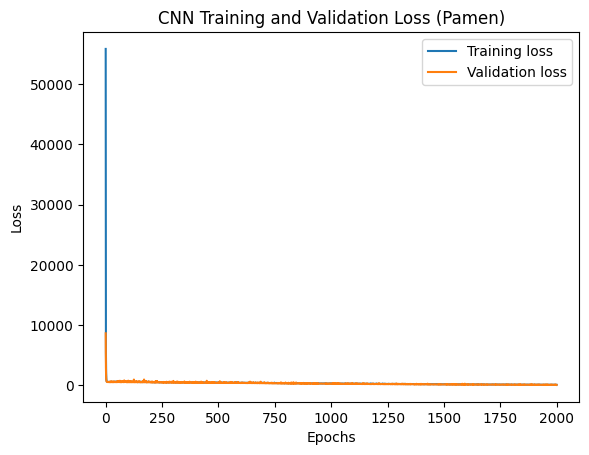

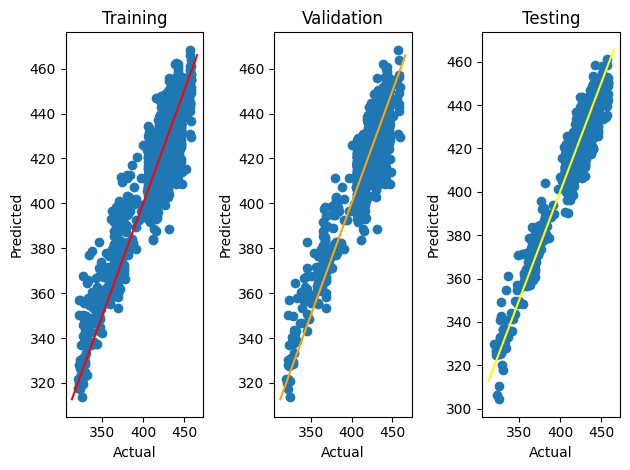

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_cnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_cnn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
with strategy.scope():
  # Start MLflow run
  with mlflow.start_run():

      # Log parameters
      mlflow.set_tag("programmer", "Berchie")
      mlflow.set_tag("model_type", "convolutional_neural_network")
      mlflow.set_tag("tensorflow_version", tf.__version__)
      mlflow.set_tag("experiment", "Pamen")
      mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Pamen.csv")
      mlflow.log_param('epochs', epochs)
      mlflow.log_param('batch_size', batch_size)

      #Convolutional neural network model architecture
      cnn_model = Sequential()
      cnn_model.add(Conv1D(1000, 3, activation="relu", input_shape=(x_train.shape[1], 1)))
      cnn_model.add(MaxPooling1D(pool_size=2))
      cnn_model.add(Dense(500, activation='relu'))
      cnn_model.add(Flatten())
      cnn_model.add(Dense(250, activation='relu'))
      cnn_model.add(Dense(1, activation='linear'))

      # Log the model architecture using mlflow.tensorflow
      mlflow.tensorflow.log_model(cnn_model, 'cnn_model')

      cnn_model.summary()

      cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

      earlyStop = EarlyStopping(monitor='val_loss',
                              mode='min',
                              patience=patience)

      history = cnn_model.fit(x_train_cnn, y_train,
                        epochs=epochs,
                        callbacks=[earlyStop],
                        batch_size=batch_size,
                        validation_data=(x_val_cnn, y_val),
                        verbose=1)
      # Log metrics
      mlflow.log_metric('pamen_final_training_loss', history.history['loss'][-1])
      mlflow.log_metric('pamen_final_validation_loss', history.history['val_loss'][-1])

      # Predictions
      train_preds = cnn_model.predict(x_train_cnn)
      val_preds = cnn_model.predict(x_val_cnn)
      test_preds = cnn_model.predict(x_test_cnn)

      # Evaluate on test set
      cnn_results = cnn_model.evaluate(x_test_cnn, y_test)

      # Mean Absolute Error (MAE)
      cnn_train_mae = mean_absolute_error(y_train, train_preds)
      cnn_val_mae = mean_absolute_error(y_val, val_preds)
      cnn_test_mae = cnn_results[1]

      # Mean Square Error (MAE)
      cnn_train_mse = mean_squared_error(y_train, train_preds)
      cnn_val_mse = mean_squared_error(y_val, val_preds)
      cnn_test_mse = cnn_results[0]

      # Root Mean Squared Error
      cnn_train_rmse = np.sqrt(cnn_train_mse)
      cnn_val_rmse = np.sqrt(cnn_val_mse)
      cnn_test_rmse = np.sqrt(cnn_test_mse)

      # R-Squared
      cnn_train_r2 = r2_score(y_train, train_preds)
      cnn_val_r2 = r2_score(y_val, val_preds)
      cnn_test_r2 = r2_score(y_test, test_preds)

      # Mean Absolute Percentage Error
      cnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
      cnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
      cnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

      # AIC calculation for the CNN
      n_samples_cnn = len(y_train)
      log_likelihood_cnn = -0.5 * n_samples_cnn * np.log(2 * np.pi * cnn_train_mse) - 0.5 * n_samples_cnn
      n_params_cnn = sum([np.prod(w.shape) for w in cnn_model.get_weights()])
      aic_cnn = -2 * log_likelihood_cnn + 2 * n_params_cnn

      # Log AIC as a metric
      mlflow.log_metric("pamen_aic_cnn", aic_cnn)

      # Logging metrics
      mlflow.log_metric('pamen_cnn_train_mae', cnn_train_mae)
      mlflow.log_metric('pamen_cnn_val_mae', cnn_val_mae)
      mlflow.log_metric('pamen_cnn_test_mae', cnn_test_mae)

      mlflow.log_metric('pamen_cnn_train_mse', cnn_train_mse)
      mlflow.log_metric('pamen_cnn_val_mse', cnn_val_mse)
      mlflow.log_metric('pamen_cnn_test_mse', cnn_test_mse)

      mlflow.log_metric("pamen_cnn_train_rmse", cnn_train_rmse)
      mlflow.log_metric("pamen_cnn_val_rmse", cnn_val_rmse)
      mlflow.log_metric("pamen_cnn_test_rmse", cnn_test_rmse)

      mlflow.log_metric("pamen_cnn_train_r2", cnn_train_r2)
      mlflow.log_metric("pamen_cnn_val_r2", cnn_val_r2)
      mlflow.log_metric("pamen_cnn_test_r2", cnn_test_r2)

      mlflow.log_metric("pamen_cnn_train_mape", cnn_train_mape)
      mlflow.log_metric("pamen_cnn_val_mape", cnn_val_mape)
      mlflow.log_metric("pamen_cnn_test_mape", cnn_test_mape)

      # Plot and save training/validation loss
      plt.plot(history.history['loss'], label='Training loss')
      plt.plot(history.history['val_loss'], label='Validation loss')
      plt.title('CNN Training and Validation Loss (Pamen)')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      loss_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_cnn_loss_plot.png'
      plt.savefig(loss_plot_path)
      mlflow.log_artifact(loss_plot_path)

      # Log scatter plots
      fig, axes = plt.subplots(1, 3)

      # Training Results
      axes[0].scatter(x=y_train, y=train_preds)
      axes[0].set_xlabel("Actual", fontsize=10)
      axes[0].set_ylabel("Predicted", fontsize=10)
      axes[0].set_title("Training")

      x = np.linspace(*axes[0].get_xlim())
      axes[0].plot(x, x, color='red')

      # Validation Results
      axes[1].scatter(x=y_val, y=val_preds)
      axes[1].set_xlabel("Actual", fontsize=10)
      axes[1].set_ylabel("Predicted", fontsize=10)
      axes[1].set_title("Validation")

      x = np.linspace(*axes[1].get_xlim())
      axes[1].plot(x, x, color='orange')

      # Testing Results
      test_preds = ffn_model.predict(x_test)
      axes[2].scatter(x=y_test, y=test_preds)
      axes[2].set_xlabel("Actual", fontsize=10)
      axes[2].set_ylabel("Predicted", fontsize=10)
      axes[2].set_title("Testing")

      x = np.linspace(*axes[2].get_xlim())
      axes[2].plot(x, x, color='yellow')

      # Tight layout
      fig.tight_layout()

      plt.show()

      # Save scatter plot
      scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_cnn_scatter_plot.png'
      plt.savefig(scatter_plot_path)
      mlflow.log_artifact(scatter_plot_path)


      # Save the model as a TensorFlow SavedModel (optional)
      saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_cnn_saved_model'
      cnn_model.save(saved_model_path)

      # Log the SavedModel as an artifact
      mlflow.log_artifact(saved_model_path)

      # End the MLflow run
      mlflow.end_run()

### 3. Long Short-Term Memory RNN

2024/01/28 08:27:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp5fi8r3qa\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp5fi8r3qa\model\data\model\assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense_15 (Dense)            (None, 500)               500500    
                                                                 
 dense_16 (Dense)            (None, 250)               125250    
                                                                 
 dense_17 (Dense)            (None, 1)                 251       
                                                                 
Total params: 4634001 (17.68 MB)
Trainable params: 4634001 (17.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
65/65 [==============================] - 11s 149ms/step - loss: 176839.2812 - mae: 396.1427 - val_loss: 107800.0078 - val_mae: 311.40

Epoch 52/2000
65/65 [==============================] - 12s 179ms/step - loss: 601.7231 - mae: 17.5036 - val_loss: 536.9515 - val_mae: 15.9140
Epoch 53/2000
65/65 [==============================] - 12s 183ms/step - loss: 638.6074 - mae: 18.2257 - val_loss: 602.2896 - val_mae: 15.6362
Epoch 54/2000
65/65 [==============================] - 12s 178ms/step - loss: 623.7762 - mae: 17.9060 - val_loss: 541.6052 - val_mae: 15.6651
Epoch 55/2000
65/65 [==============================] - 12s 183ms/step - loss: 703.6188 - mae: 19.5130 - val_loss: 554.1296 - val_mae: 17.3848
Epoch 56/2000
65/65 [==============================] - 11s 176ms/step - loss: 655.3138 - mae: 18.6743 - val_loss: 749.2331 - val_mae: 23.3794
Epoch 57/2000
65/65 [==============================] - 12s 183ms/step - loss: 587.8440 - mae: 17.3285 - val_loss: 566.0342 - val_mae: 18.0189
Epoch 58/2000
65/65 [==============================] - 12s 184ms/step - loss: 645.7059 - mae: 18.5004 - val_loss: 628.0872 - val_mae: 20.2694
Epoch 

Epoch 110/2000
65/65 [==============================] - 10s 157ms/step - loss: 608.1619 - mae: 17.8469 - val_loss: 559.7952 - val_mae: 15.2844
Epoch 111/2000
65/65 [==============================] - 10s 157ms/step - loss: 615.4275 - mae: 17.8160 - val_loss: 577.2198 - val_mae: 18.6077
Epoch 112/2000
65/65 [==============================] - 11s 164ms/step - loss: 575.4801 - mae: 17.0519 - val_loss: 654.9139 - val_mae: 16.3642
Epoch 113/2000
65/65 [==============================] - 11s 171ms/step - loss: 598.7987 - mae: 17.6723 - val_loss: 593.5219 - val_mae: 15.5875
Epoch 114/2000
65/65 [==============================] - 10s 156ms/step - loss: 618.9893 - mae: 17.9897 - val_loss: 708.8146 - val_mae: 22.6266
Epoch 115/2000
65/65 [==============================] - 10s 151ms/step - loss: 651.2939 - mae: 18.6237 - val_loss: 570.5292 - val_mae: 18.4222
Epoch 116/2000
65/65 [==============================] - 10s 160ms/step - loss: 563.5273 - mae: 16.9662 - val_loss: 550.6088 - val_mae: 15.4443

65/65 [==============================] - 10s 149ms/step - loss: 551.1117 - mae: 16.7644 - val_loss: 558.4675 - val_mae: 15.5092
Epoch 168/2000
65/65 [==============================] - 10s 154ms/step - loss: 587.7951 - mae: 17.4289 - val_loss: 525.9994 - val_mae: 15.6972
Epoch 169/2000
65/65 [==============================] - 10s 157ms/step - loss: 599.4880 - mae: 17.7202 - val_loss: 534.4141 - val_mae: 15.3128
Epoch 170/2000
65/65 [==============================] - 11s 172ms/step - loss: 610.5473 - mae: 17.8920 - val_loss: 1131.3380 - val_mae: 30.8942
Epoch 171/2000
65/65 [==============================] - 11s 169ms/step - loss: 594.3066 - mae: 17.6806 - val_loss: 702.8295 - val_mae: 17.3858
Epoch 172/2000
65/65 [==============================] - 10s 157ms/step - loss: 590.1996 - mae: 17.4947 - val_loss: 535.7986 - val_mae: 15.5219
Epoch 173/2000
65/65 [==============================] - 11s 163ms/step - loss: 547.0826 - mae: 16.5980 - val_loss: 573.9052 - val_mae: 15.7233
Epoch 174/200

65/65 [==============================] - 9s 145ms/step - loss: 566.2174 - mae: 17.2562 - val_loss: 551.6072 - val_mae: 15.7737
Epoch 225/2000
65/65 [==============================] - 9s 143ms/step - loss: 521.2899 - mae: 16.4710 - val_loss: 496.2075 - val_mae: 15.6899
Epoch 226/2000
65/65 [==============================] - 10s 152ms/step - loss: 510.0289 - mae: 16.0671 - val_loss: 518.0822 - val_mae: 16.4236
Epoch 227/2000
65/65 [==============================] - 9s 142ms/step - loss: 539.9519 - mae: 16.6488 - val_loss: 521.9429 - val_mae: 17.2718
Epoch 228/2000
65/65 [==============================] - 9s 144ms/step - loss: 530.6848 - mae: 16.7300 - val_loss: 532.0400 - val_mae: 15.9648
Epoch 229/2000
65/65 [==============================] - 10s 150ms/step - loss: 542.1024 - mae: 16.8160 - val_loss: 533.0011 - val_mae: 15.2761
Epoch 230/2000
65/65 [==============================] - 10s 150ms/step - loss: 521.3309 - mae: 16.3949 - val_loss: 514.6332 - val_mae: 16.7457
Epoch 231/2000
65/

Epoch 282/2000
65/65 [==============================] - 9s 132ms/step - loss: 466.6687 - mae: 15.2995 - val_loss: 459.5753 - val_mae: 15.3726
Epoch 283/2000
65/65 [==============================] - 9s 131ms/step - loss: 473.1109 - mae: 15.6370 - val_loss: 450.4657 - val_mae: 15.1355
Epoch 284/2000
65/65 [==============================] - 9s 132ms/step - loss: 499.9304 - mae: 16.2701 - val_loss: 458.1559 - val_mae: 15.0855
Epoch 285/2000
65/65 [==============================] - 9s 139ms/step - loss: 480.8237 - mae: 15.7621 - val_loss: 473.8125 - val_mae: 15.1216
Epoch 286/2000
65/65 [==============================] - 9s 139ms/step - loss: 480.4527 - mae: 15.7428 - val_loss: 459.5383 - val_mae: 14.8280
Epoch 287/2000
65/65 [==============================] - 9s 139ms/step - loss: 492.6693 - mae: 16.2059 - val_loss: 475.8183 - val_mae: 16.2182
Epoch 288/2000
65/65 [==============================] - 9s 133ms/step - loss: 499.3714 - mae: 16.2899 - val_loss: 464.5684 - val_mae: 14.6726
Epoch 

65/65 [==============================] - 9s 137ms/step - loss: 405.8068 - mae: 14.7774 - val_loss: 344.5915 - val_mae: 13.2876
Epoch 340/2000
65/65 [==============================] - 9s 138ms/step - loss: 372.1924 - mae: 13.8214 - val_loss: 388.0962 - val_mae: 15.3671
Epoch 341/2000
65/65 [==============================] - 9s 138ms/step - loss: 378.2699 - mae: 14.1786 - val_loss: 358.5049 - val_mae: 13.1888
Epoch 342/2000
65/65 [==============================] - 11s 166ms/step - loss: 392.5294 - mae: 14.4431 - val_loss: 343.0223 - val_mae: 12.8439
Epoch 343/2000
65/65 [==============================] - 10s 160ms/step - loss: 373.2384 - mae: 13.8512 - val_loss: 332.4343 - val_mae: 13.0589
Epoch 344/2000
65/65 [==============================] - 9s 138ms/step - loss: 363.8633 - mae: 13.5921 - val_loss: 342.4030 - val_mae: 13.7714
Epoch 345/2000
65/65 [==============================] - 9s 139ms/step - loss: 350.0577 - mae: 13.4109 - val_loss: 331.4657 - val_mae: 13.1994
Epoch 346/2000
65/6

Epoch 397/2000
65/65 [==============================] - 9s 138ms/step - loss: 199.6074 - mae: 10.5744 - val_loss: 183.0126 - val_mae: 9.6455
Epoch 398/2000
65/65 [==============================] - 9s 135ms/step - loss: 177.1814 - mae: 9.5245 - val_loss: 149.7254 - val_mae: 8.6468
Epoch 399/2000
65/65 [==============================] - 10s 158ms/step - loss: 193.9113 - mae: 10.0227 - val_loss: 158.4657 - val_mae: 8.7521
Epoch 400/2000
65/65 [==============================] - 10s 157ms/step - loss: 173.8388 - mae: 9.5317 - val_loss: 189.1282 - val_mae: 9.6060
Epoch 401/2000
65/65 [==============================] - 9s 140ms/step - loss: 173.7267 - mae: 9.5170 - val_loss: 192.9247 - val_mae: 10.9056
Epoch 402/2000
65/65 [==============================] - 9s 141ms/step - loss: 176.6025 - mae: 9.6617 - val_loss: 153.6967 - val_mae: 9.0445
Epoch 403/2000
65/65 [==============================] - 9s 138ms/step - loss: 166.3026 - mae: 9.3448 - val_loss: 156.7268 - val_mae: 8.9734
Epoch 404/2000


Epoch 456/2000
65/65 [==============================] - 9s 136ms/step - loss: 118.3436 - mae: 7.7183 - val_loss: 81.3400 - val_mae: 6.5048
Epoch 457/2000
65/65 [==============================] - 9s 133ms/step - loss: 65.8451 - mae: 5.9646 - val_loss: 51.2838 - val_mae: 5.1669
Epoch 458/2000
65/65 [==============================] - 9s 138ms/step - loss: 55.0642 - mae: 5.5525 - val_loss: 43.6048 - val_mae: 4.8552
Epoch 459/2000
65/65 [==============================] - 10s 147ms/step - loss: 53.5671 - mae: 5.3920 - val_loss: 53.0980 - val_mae: 5.2897
Epoch 460/2000
65/65 [==============================] - 9s 142ms/step - loss: 47.8362 - mae: 5.1376 - val_loss: 38.2261 - val_mae: 4.6545
Epoch 461/2000
65/65 [==============================] - 9s 137ms/step - loss: 43.1899 - mae: 4.8468 - val_loss: 41.1959 - val_mae: 4.6518
Epoch 462/2000
65/65 [==============================] - 9s 135ms/step - loss: 46.4633 - mae: 4.8819 - val_loss: 41.7148 - val_mae: 4.8397
Epoch 463/2000
65/65 [==========

65/65 [==============================] - 9s 146ms/step - loss: 64.5108 - mae: 5.9480 - val_loss: 37.6657 - val_mae: 4.6381
Epoch 516/2000
65/65 [==============================] - 9s 137ms/step - loss: 38.1744 - mae: 4.6160 - val_loss: 23.9993 - val_mae: 3.6787
Epoch 517/2000
65/65 [==============================] - 9s 141ms/step - loss: 20.7130 - mae: 3.3946 - val_loss: 17.7832 - val_mae: 3.1481
Epoch 518/2000
65/65 [==============================] - 9s 138ms/step - loss: 16.0526 - mae: 2.9675 - val_loss: 11.1708 - val_mae: 2.4776
Epoch 519/2000
65/65 [==============================] - 9s 142ms/step - loss: 14.8407 - mae: 2.7688 - val_loss: 12.4818 - val_mae: 2.5578
Epoch 520/2000
65/65 [==============================] - 9s 141ms/step - loss: 13.4462 - mae: 2.6732 - val_loss: 12.3672 - val_mae: 2.5970
Epoch 521/2000
65/65 [==============================] - 9s 143ms/step - loss: 12.2548 - mae: 2.5600 - val_loss: 8.6855 - val_mae: 2.2490
Epoch 522/2000
65/65 [============================

65/65 [==============================] - 9s 136ms/step - loss: 57.9746 - mae: 5.4150 - val_loss: 37.6106 - val_mae: 4.5075
Epoch 575/2000
65/65 [==============================] - 9s 136ms/step - loss: 39.6642 - mae: 4.6059 - val_loss: 26.7085 - val_mae: 3.8522
Epoch 576/2000
65/65 [==============================] - 9s 137ms/step - loss: 25.8397 - mae: 3.7876 - val_loss: 13.9335 - val_mae: 2.7916
Epoch 577/2000
65/65 [==============================] - 9s 145ms/step - loss: 13.3027 - mae: 2.7637 - val_loss: 7.6615 - val_mae: 2.1152
Epoch 578/2000
65/65 [==============================] - 9s 142ms/step - loss: 10.9160 - mae: 2.4314 - val_loss: 7.8328 - val_mae: 2.1586
Epoch 579/2000
65/65 [==============================] - 9s 144ms/step - loss: 6.3290 - mae: 1.8465 - val_loss: 7.7171 - val_mae: 2.2487
Epoch 580/2000
65/65 [==============================] - 10s 160ms/step - loss: 8.9857 - mae: 2.1682 - val_loss: 6.1217 - val_mae: 1.8297
Epoch 581/2000
65/65 [==============================] 

Epoch 634/2000
65/65 [==============================] - 10s 148ms/step - loss: 4.6274 - mae: 1.5486 - val_loss: 3.5465 - val_mae: 1.4127
Epoch 635/2000
65/65 [==============================] - 10s 152ms/step - loss: 4.5538 - mae: 1.4478 - val_loss: 2.7628 - val_mae: 1.2611
Epoch 636/2000
65/65 [==============================] - 10s 159ms/step - loss: 3.5418 - mae: 1.3481 - val_loss: 5.1668 - val_mae: 1.9140
Epoch 637/2000
65/65 [==============================] - 10s 160ms/step - loss: 3.8757 - mae: 1.4405 - val_loss: 5.7329 - val_mae: 2.0318
Epoch 638/2000
65/65 [==============================] - 10s 157ms/step - loss: 4.3023 - mae: 1.6035 - val_loss: 3.3694 - val_mae: 1.4398
Epoch 639/2000
65/65 [==============================] - 9s 146ms/step - loss: 6.0554 - mae: 1.9047 - val_loss: 4.7593 - val_mae: 1.6205
Epoch 640/2000
65/65 [==============================] - 9s 141ms/step - loss: 7.9878 - mae: 2.1504 - val_loss: 6.8153 - val_mae: 1.9575
Epoch 641/2000
65/65 [=====================

65/65 [==============================] - 10s 157ms/step - loss: 3.5800 - mae: 1.4018 - val_loss: 3.4741 - val_mae: 1.4279
Epoch 694/2000
65/65 [==============================] - 10s 152ms/step - loss: 3.8303 - mae: 1.3673 - val_loss: 2.6581 - val_mae: 1.2529
Epoch 695/2000
65/65 [==============================] - 10s 154ms/step - loss: 4.9180 - mae: 1.4966 - val_loss: 6.5239 - val_mae: 1.9929
Epoch 696/2000
65/65 [==============================] - 10s 151ms/step - loss: 6.6883 - mae: 1.7279 - val_loss: 7.0736 - val_mae: 1.8607
Epoch 697/2000
65/65 [==============================] - 10s 156ms/step - loss: 8.2981 - mae: 2.0363 - val_loss: 5.9599 - val_mae: 1.8029
Epoch 698/2000
65/65 [==============================] - 9s 145ms/step - loss: 15.4862 - mae: 2.9690 - val_loss: 10.6181 - val_mae: 2.4625
Epoch 699/2000
65/65 [==============================] - 9s 141ms/step - loss: 20.1301 - mae: 3.4028 - val_loss: 35.7003 - val_mae: 5.0495
Epoch 700/2000
65/65 [==============================] 

Epoch 753/2000
65/65 [==============================] - 12s 177ms/step - loss: 6.3373 - mae: 1.8968 - val_loss: 5.2508 - val_mae: 1.6858
Epoch 754/2000
65/65 [==============================] - 12s 184ms/step - loss: 7.4038 - mae: 2.0901 - val_loss: 6.0746 - val_mae: 1.8682
Epoch 755/2000
65/65 [==============================] - 12s 177ms/step - loss: 6.6454 - mae: 1.9088 - val_loss: 7.3971 - val_mae: 2.0762
Epoch 756/2000
65/65 [==============================] - 11s 170ms/step - loss: 7.3172 - mae: 2.0037 - val_loss: 7.1263 - val_mae: 2.0436
Epoch 757/2000
65/65 [==============================] - 11s 169ms/step - loss: 10.9790 - mae: 2.4995 - val_loss: 8.3218 - val_mae: 2.0816
Epoch 758/2000
65/65 [==============================] - 11s 169ms/step - loss: 10.0774 - mae: 2.3227 - val_loss: 10.7523 - val_mae: 2.4902
Epoch 759/2000
65/65 [==============================] - 11s 165ms/step - loss: 18.9845 - mae: 3.2005 - val_loss: 16.7021 - val_mae: 3.0038
Epoch 760/2000
65/65 [==============

65/65 [==============================] - 11s 162ms/step - loss: 12.0110 - mae: 2.5970 - val_loss: 27.6626 - val_mae: 3.5104
Epoch 813/2000
65/65 [==============================] - 10s 162ms/step - loss: 56.1219 - mae: 4.8276 - val_loss: 83.2681 - val_mae: 5.5031
Epoch 814/2000
65/65 [==============================] - 10s 153ms/step - loss: 118.9126 - mae: 7.7409 - val_loss: 85.4549 - val_mae: 6.2834
Epoch 815/2000
65/65 [==============================] - 10s 155ms/step - loss: 92.5616 - mae: 6.9264 - val_loss: 65.6411 - val_mae: 5.3739
Epoch 816/2000
65/65 [==============================] - 10s 153ms/step - loss: 61.2157 - mae: 5.4926 - val_loss: 25.4981 - val_mae: 3.7244
Epoch 817/2000
65/65 [==============================] - 11s 164ms/step - loss: 22.0692 - mae: 3.4537 - val_loss: 9.8686 - val_mae: 2.3778
Epoch 818/2000
65/65 [==============================] - 12s 186ms/step - loss: 9.8564 - mae: 2.3227 - val_loss: 4.8735 - val_mae: 1.6762
Epoch 819/2000
65/65 [======================

65/65 [==============================] - 14s 209ms/step - loss: 1.8748 - mae: 0.8915 - val_loss: 0.7670 - val_mae: 0.6747
Epoch 872/2000
65/65 [==============================] - 15s 226ms/step - loss: 1.1820 - mae: 0.8175 - val_loss: 0.9490 - val_mae: 0.7660
Epoch 873/2000
65/65 [==============================] - 17s 255ms/step - loss: 0.9712 - mae: 0.7537 - val_loss: 1.5079 - val_mae: 1.0373
Epoch 874/2000
65/65 [==============================] - 13s 198ms/step - loss: 0.9835 - mae: 0.7642 - val_loss: 2.3062 - val_mae: 1.3204
Epoch 875/2000
65/65 [==============================] - 11s 172ms/step - loss: 1.3930 - mae: 0.9188 - val_loss: 1.0764 - val_mae: 0.8285
Epoch 876/2000
65/65 [==============================] - 12s 180ms/step - loss: 1.5132 - mae: 0.9667 - val_loss: 1.3512 - val_mae: 0.9090
Epoch 877/2000
65/65 [==============================] - 11s 171ms/step - loss: 1.1529 - mae: 0.8229 - val_loss: 0.8681 - val_mae: 0.7290
Epoch 878/2000
65/65 [==============================] - 

Epoch 931/2000
65/65 [==============================] - 10s 160ms/step - loss: 1.7738 - mae: 0.9689 - val_loss: 0.9158 - val_mae: 0.7412
Epoch 932/2000
65/65 [==============================] - 11s 164ms/step - loss: 1.2952 - mae: 0.8031 - val_loss: 0.7530 - val_mae: 0.6629
Epoch 933/2000
65/65 [==============================] - 10s 161ms/step - loss: 1.0840 - mae: 0.7317 - val_loss: 0.7002 - val_mae: 0.6379
Epoch 934/2000
65/65 [==============================] - 11s 166ms/step - loss: 0.9629 - mae: 0.6781 - val_loss: 0.5005 - val_mae: 0.5455
Epoch 935/2000
65/65 [==============================] - 10s 159ms/step - loss: 0.7810 - mae: 0.6515 - val_loss: 0.5754 - val_mae: 0.5682
Epoch 936/2000
65/65 [==============================] - 10s 159ms/step - loss: 0.6745 - mae: 0.6240 - val_loss: 0.4702 - val_mae: 0.5263
Epoch 937/2000
65/65 [==============================] - 10s 159ms/step - loss: 0.6108 - mae: 0.5781 - val_loss: 0.7457 - val_mae: 0.7028
Epoch 938/2000
65/65 [===================

65/65 [==============================] - 10s 156ms/step - loss: 7.1307 - mae: 1.9939 - val_loss: 4.6457 - val_mae: 1.6726
Epoch 991/2000
65/65 [==============================] - 10s 154ms/step - loss: 4.1820 - mae: 1.5519 - val_loss: 2.4818 - val_mae: 1.2260
Epoch 992/2000
65/65 [==============================] - 10s 154ms/step - loss: 2.4444 - mae: 1.2014 - val_loss: 1.8164 - val_mae: 1.0589
Epoch 993/2000
65/65 [==============================] - 10s 159ms/step - loss: 1.7854 - mae: 1.0285 - val_loss: 1.8249 - val_mae: 1.0879
Epoch 994/2000
65/65 [==============================] - 10s 156ms/step - loss: 1.1113 - mae: 0.8131 - val_loss: 0.7057 - val_mae: 0.6487
Epoch 995/2000
65/65 [==============================] - 10s 154ms/step - loss: 0.7820 - mae: 0.6939 - val_loss: 0.6656 - val_mae: 0.6442
Epoch 996/2000
65/65 [==============================] - 10s 154ms/step - loss: 0.6595 - mae: 0.6259 - val_loss: 0.4101 - val_mae: 0.4966
Epoch 997/2000
65/65 [==============================] - 

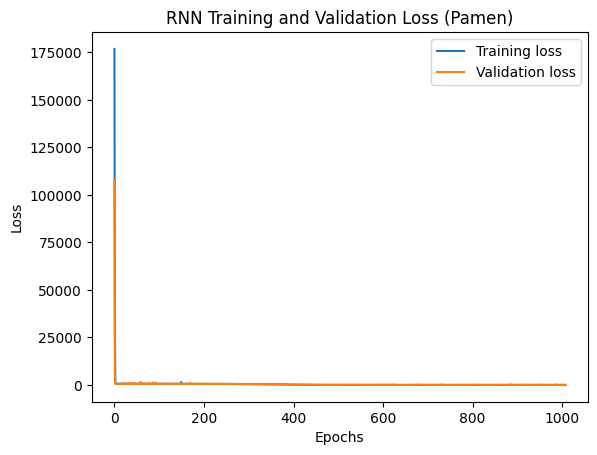

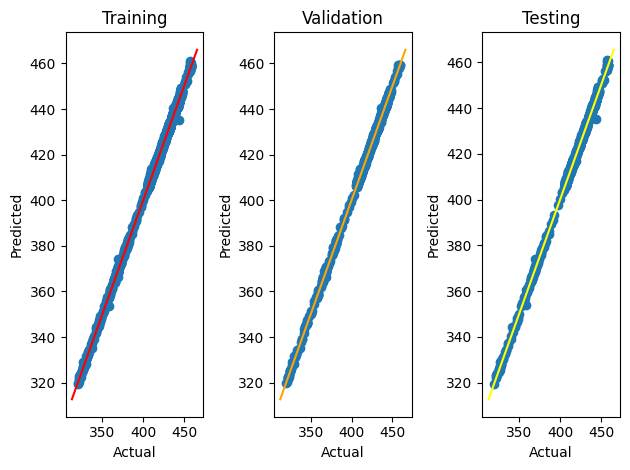

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_rnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_rnn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
with strategy.scope():
  # Start MLflow run
  with mlflow.start_run():

      # Log parameters
      mlflow.set_tag("programmer", "Berchie")
      mlflow.set_tag("model_type", "recurrent_neural_network")
      mlflow.set_tag("tensorflow_version", tf.__version__)
      mlflow.set_tag("experiment", "Pamen")
      mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data")
      mlflow.log_param('epochs', epochs)
      mlflow.log_param('batch_size', batch_size)

      # Recurrent neural network model architecture (LSTM)
      rnn_model = Sequential()
      rnn_model.add(LSTM(1000, activation="relu", input_shape=(x_train.shape[1], 1)))
      rnn_model.add(Dense(500, activation='relu'))
      rnn_model.add(Dense(250, activation='relu'))
      rnn_model.add(Dense(1, activation='linear'))

      # Log the model architecture using mlflow.tensorflow
      mlflow.tensorflow.log_model(rnn_model, 'rnn_model')

      rnn_model.summary()

      rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

      earlyStop = EarlyStopping(monitor='val_loss',
                              mode='min',
                              patience=patience)

      history = rnn_model.fit(x_train_cnn, y_train,
                              epochs=epochs,
                              callbacks=[earlyStop],
                              batch_size=batch_size,
                              validation_data=(x_val_cnn, y_val),
                              verbose=1)

      # Log metrics
      mlflow.log_metric('pamen_final_training_loss', history.history['loss'][-1])
      mlflow.log_metric('pamen_final_validation_loss', history.history['val_loss'][-1])

      # Predictions
      train_preds = rnn_model.predict(x_train_cnn)
      val_preds = rnn_model.predict(x_val_cnn)
      test_preds = rnn_model.predict(x_test_cnn)

      # Evaluate on the test set
      rnn_results = rnn_model.evaluate(x_test_cnn, y_test)

      # MAE
      rnn_train_mae = mean_absolute_error(y_train, train_preds)
      rnn_val_mae = mean_absolute_error(y_val, val_preds)
      rnn_test_mae = rnn_results[1]

      # MSE
      rnn_train_mse = mean_squared_error(y_train, train_preds)
      rnn_val_mse = mean_squared_error(y_val, val_preds)
      rnn_test_mse = rnn_results[0]

      # RMSE
      rnn_train_rmse = np.sqrt(rnn_train_mse)
      rnn_val_rmse = np.sqrt(rnn_val_mse)
      rnn_test_rmse = np.sqrt(rnn_test_mse)

      # R-Square
      rnn_train_r2 = r2_score(y_train, train_preds)
      rnn_val_r2 = r2_score(y_val, val_preds)
      rnn_test_r2 = r2_score(y_test, test_preds)

      # MAPE
      rnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
      rnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
      rnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

      # AIC calculation for the RNN
      n_samples_rnn = len(y_train)
      log_likelihood_rnn = -0.5 * n_samples_rnn * np.log(2 * np.pi * rnn_train_mse) - 0.5 * n_samples_rnn
      n_params_rnn = sum([np.prod(w.shape) for w in rnn_model.get_weights()])
      aic_rnn = -2 * log_likelihood_rnn + 2 * n_params_rnn

      # Log AIC as a metric
      mlflow.log_metric("pamen_aic_rnn", aic_rnn)

      # Logging metrics
      mlflow.log_metric('pamen_rnn_train_mae', rnn_train_mae)
      mlflow.log_metric('pamen_rnn_val_mae', rnn_val_mae)
      mlflow.log_metric('pamen_rnn_test_mae', rnn_test_mae)

      mlflow.log_metric('pamen_rnn_train_mse', rnn_train_mse)
      mlflow.log_metric('pamen_rnn_val_mse', rnn_val_mse)
      mlflow.log_metric('pamen_rnn_test_mse', rnn_test_mse)

      mlflow.log_metric("pamen_rnn_train_rmse", rnn_train_rmse)
      mlflow.log_metric("pamen_rnn_val_rmse", rnn_val_rmse)
      mlflow.log_metric("pamen_rnn_test_rmse", rnn_test_rmse)

      mlflow.log_metric("pamen_rnn_train_r2", rnn_train_r2)
      mlflow.log_metric("pamen_rnn_val_r2", rnn_val_r2)
      mlflow.log_metric("pamen_rnn_test_r2", rnn_test_r2)

      mlflow.log_metric("pamen_rnn_train_mape", rnn_train_mape)
      mlflow.log_metric("pamen_rnn_val_mape", rnn_val_mape)
      mlflow.log_metric("pamen_rnn_test_mape", rnn_test_mape)

      # Plot and save training/validation loss
      plt.plot(history.history['loss'], label='Training loss')
      plt.plot(history.history['val_loss'], label='Validation loss')
      plt.title('RNN Training and Validation Loss (Pamen)')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      loss_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_rnn_loss_plot.png'

      plt.savefig(loss_plot_path)
      mlflow.log_artifact(loss_plot_path)

      # Log scatter plots
      fig, axes = plt.subplots(1, 3)

      # Training Results
      axes[0].scatter(x=y_train, y=train_preds)
      axes[0].set_xlabel("Actual", fontsize=10)
      axes[0].set_ylabel("Predicted", fontsize=10)
      axes[0].set_title("Training")

      x = np.linspace(*axes[0].get_xlim())
      axes[0].plot(x, x, color='red')

      # Validation Results
      axes[1].scatter(x=y_val, y=val_preds)
      axes[1].set_xlabel("Actual", fontsize=10)
      axes[1].set_ylabel("Predicted", fontsize=10)
      axes[1].set_title("Validation")

      x = np.linspace(*axes[1].get_xlim())
      axes[1].plot(x, x, color='orange')

      # Testing Results
      axes[2].scatter(x=y_test, y=test_preds)
      axes[2].set_xlabel("Actual", fontsize=10)
      axes[2].set_ylabel("Predicted", fontsize=10)
      axes[2].set_title("Testing")

      x = np.linspace(*axes[2].get_xlim())
      axes[2].plot(x, x, color='yellow')

      # Tight layout
      fig.tight_layout()

      plt.show()

      # Save scatter plot
      scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_rnn_scatter_plot.png'
      plt.savefig(scatter_plot_path)
      mlflow.log_artifact(scatter_plot_path)

      # Save the model as a TensorFlow SavedModel (optional)
      saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_rnn_saved_model'
      rnn_model.save(saved_model_path)

      # Log the SavedModel as an artifact
      mlflow.log_artifact(saved_model_path)
      mlflow.end_run()

In [ ]:
from tensorflow.keras.models import save_model

# Save Feedforward Neural Network (FFN) model
ffn_model.save("ffn_model.h5")

# Save Convolutional Neural Network (CNN) model
cnn_model.save("cnn_model.h5")

# Save Recurrent Neural Network (RNN) model
rnn_model.save("rnn_model.h5")


D:\RGT\Code\MLOps\mlopsenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4. Neural Network Ensemble

51/51 [==============================] - 1s 19ms/step
Epoch 1/20
26/26 [==============================] - 1s 7ms/step - loss: 314324.0938 - mae: 552.9251 - val_loss: 159209.2969 - val_mae: 398.3915
Epoch 2/20
26/26 [==============================] - 0s 4ms/step - loss: 83513.5078 - mae: 280.4730 - val_loss: 27494.0527 - val_mae: 165.5210
Epoch 3/20
26/26 [==============================] - 0s 3ms/step - loss: 10081.9219 - mae: 92.1547 - val_loss: 972.6604 - val_mae: 31.0189
Epoch 4/20
26/26 [==============================] - 0s 3ms/step - loss: 181.8265 - mae: 9.9553 - val_loss: 37.5490 - val_mae: 5.7383
Epoch 5/20
26/26 [==============================] - 0s 3ms/step - loss: 32.7989 - mae: 5.1861 - val_loss: 10.7339 - val_mae: 2.6813
Epoch 6/20
26/26 [==============================] - 0s 3ms/step - loss: 6.5201 - mae: 1.9413 - val_loss: 5.5024 - val_mae: 1.7163
Epoch 7/20
26/26 [==============================] - 0s 3ms/step - loss: 5.5155 - mae: 1.7525 - val_loss: 5.3340 - val_mae: 1.66

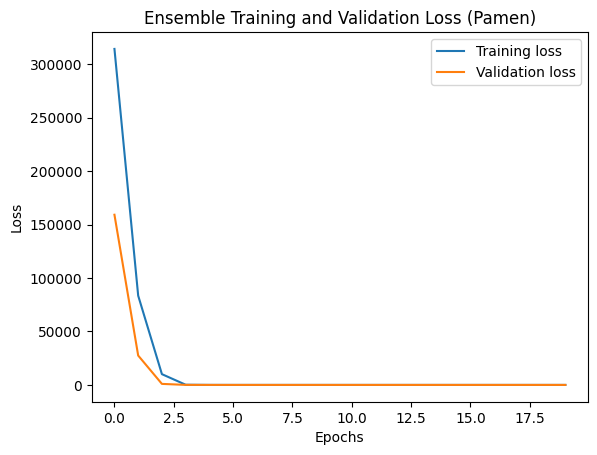

51/51 [==============================] - 0s 849us/step


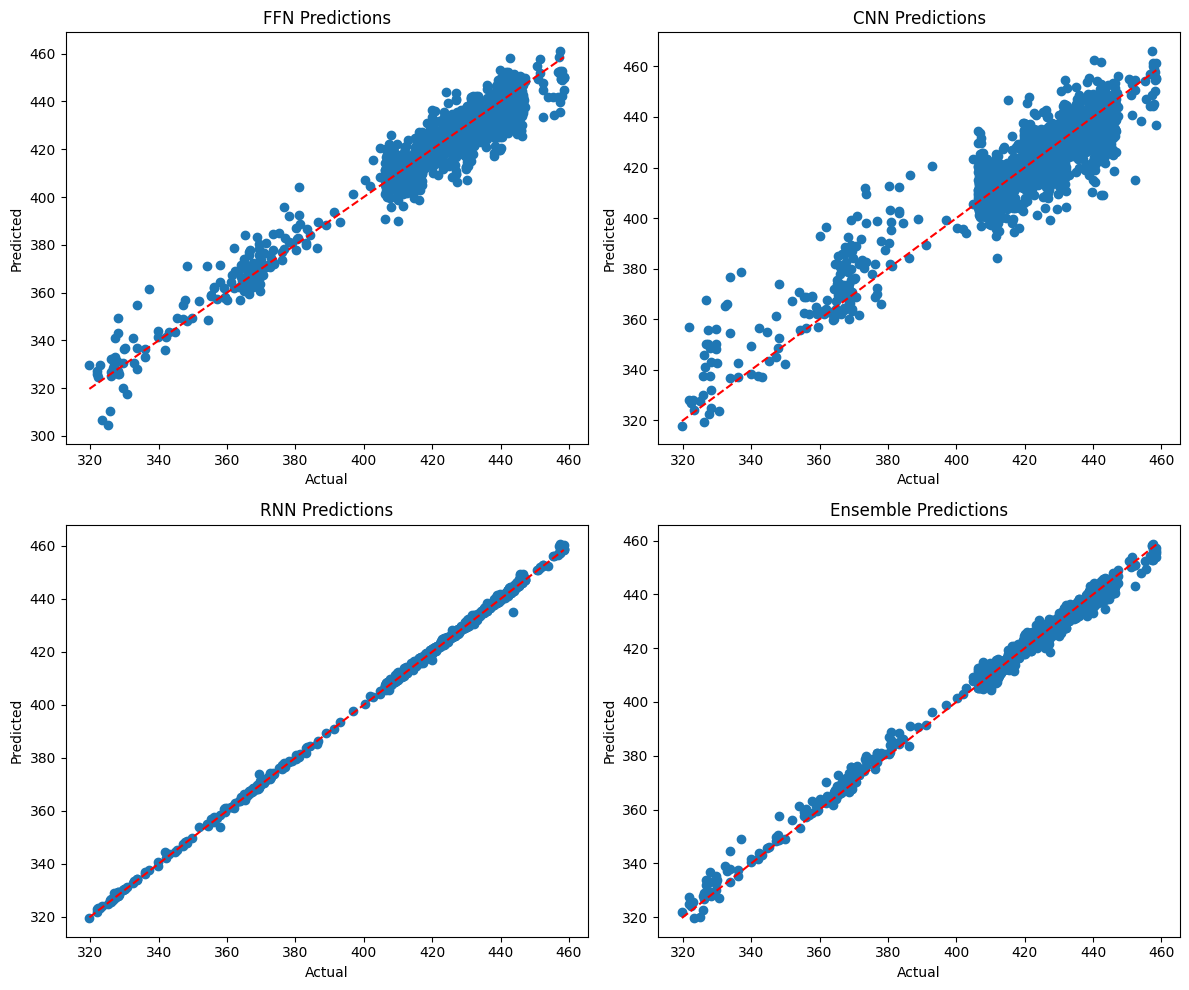

In [ ]:
import joblib

with strategy.scope():
  # Check if there is an active run
  active_run = mlflow.active_run()
  if active_run:
      # End the active run
      mlflow.end_run()

  # Starting MLflow run
  with mlflow.start_run():
      mlflow.set_tag("programmer", "Berchie")
      mlflow.set_tag("model_type", "neural_network_ensemble")
      mlflow.set_tag("tensorflow_version", tf.__version__)
      mlflow.set_tag("experiment", "Pamen")
      mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Pamen.csv")

      # Make predictions on the validation set using each model
      val_preds_ffn = ffn_model.predict(x_val)
      val_preds_cnn = cnn_model.predict(x_val_cnn)
      val_preds_rnn = rnn_model.predict(x_val_cnn)

      # Combine the predictions into a single input for the ensemble
      stacked_input_val = np.concatenate((val_preds_ffn, val_preds_cnn, val_preds_rnn), axis=1)

      # Create the Stacked Ensemble Model
      stacked_ensemble = Sequential()
      stacked_ensemble.add(Dense(100, activation='relu', input_shape=(3,)))
      stacked_ensemble.add(Dense(1, activation='linear'))

      # Compile the ensemble model
      stacked_ensemble.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

      # Train the ensemble model on the stacked predictions
      history_ensemble = stacked_ensemble.fit(stacked_input_val, y_val, epochs=20, batch_size=batch_size, validation_split=0.2)

      # Log training and validation performance
      mlflow.log_metric("pamen_ensemble_train_loss", history_ensemble.history['loss'][-1])
      mlflow.log_metric("pamen_ensemble_val_loss", history_ensemble.history['val_loss'][-1])

      # Plot the loss for the ensemble during training and validation
      plt.plot(history_ensemble.history['loss'], label='Training loss')
      plt.plot(history_ensemble.history['val_loss'], label='Validation loss')
      plt.title('Ensemble Training and Validation Loss (Pamen)')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      # Save the loss plot
      loss_plot_path_ensemble = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ensemble_loss_plot.png'
      plt.savefig(loss_plot_path_ensemble)
      mlflow.log_artifact(loss_plot_path_ensemble)

      # Show the loss plot
      plt.show()

      # Make predictions on the test set using each model
      test_preds_ffn = ffn_model.predict(x_test)
      test_preds_cnn = cnn_model.predict(x_test_cnn)
      test_preds_rnn = rnn_model.predict(x_test_cnn)

      # Combine the predictions into a single input for the ensemble
      stacked_input_test = np.concatenate((test_preds_ffn, test_preds_cnn, test_preds_rnn), axis=1)

      # Make predictions using the stacked ensemble
      ensemble_preds = stacked_ensemble.predict(stacked_input_test)

      # Scatter plots for individual models and ensemble
      fig, axes = plt.subplots(2, 2, figsize=(12, 10))

      # Feed-Forward Neural Network
      axes[0, 0].scatter(x=y_test, y=test_preds_ffn)
      axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
      axes[0, 0].set_xlabel("Actual", fontsize=10)
      axes[0, 0].set_ylabel("Predicted", fontsize=10)
      axes[0, 0].set_title("FFN Predictions")

      # Convolutional Neural Network
      axes[0, 1].scatter(x=y_test, y=test_preds_cnn)
      axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
      axes[0, 1].set_xlabel("Actual", fontsize=10)
      axes[0, 1].set_ylabel("Predicted", fontsize=10)
      axes[0, 1].set_title("CNN Predictions")

      # Long Short-Term Memory RNN
      axes[1, 0].scatter(x=y_test, y=test_preds_rnn)
      axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
      axes[1, 0].set_xlabel("Actual", fontsize=10)
      axes[1, 0].set_ylabel("Predicted", fontsize=10)
      axes[1, 0].set_title("RNN Predictions")

      # Stacked Ensemble
      axes[1, 1].scatter(x=y_test, y=ensemble_preds)
      axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
      axes[1, 1].set_xlabel("Actual", fontsize=10)
      axes[1, 1].set_ylabel("Predicted", fontsize=10)
      axes[1, 1].set_title("Ensemble Predictions")

      # Tight layout
      fig.tight_layout()

      # Save scatter plots
      scatter_plots_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ensemble_scatter_plot.png'
      plt.savefig(scatter_plots_path)
      mlflow.log_artifact(scatter_plots_path)

      # Show the scatter plots
      plt.show()

      # Evaluate the performance of the stacked ensemble
      ensemble_mse = mean_squared_error(y_test, ensemble_preds)
      ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
      ensemble_r2 = r2_score(y_test, ensemble_preds)
      ensemble_rmse = np.sqrt(ensemble_mse)
      ensemble_mape = np.mean(np.abs((y_val - ensemble_preds.flatten()) / y_val)) * 100

      # Log testing performance
      mlflow.log_metric("pamen_ensemble_test_mae", ensemble_mae)
      mlflow.log_metric("pamen_ensemble_test_mse", ensemble_mse)
      mlflow.log_metric("pamen_ensemble_test_rmse", ensemble_rmse)
      mlflow.log_metric("pamen_ensemble_test_r2", ensemble_r2)
      mlflow.log_metric("pamen_ensemble_test_mape", ensemble_mape)

      # Get the number of parameters in the ensemble model
      num_params_ensemble = stacked_ensemble.count_params()

      # Calculate AIC
      max_log_likelihood = -0.5 * min(history_ensemble.history['val_loss'])
      aic_ensemble = 2 * num_params_ensemble - 2 * max_log_likelihood

      # Log AIC
      mlflow.log_metric("pamen_ensemble_aic", aic_ensemble)

      # Saving the ensemble model as a pickle file
      joblib.dump(ensemble_model, r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ensemble_model.pkl')

      # Log the ensemble model as an artifact
      mlflow.log_artifact(r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\pamen_ensemble_model.pkl')

### Print results

In [ ]:
print("Feed Forward Neural Network Results")
print("AIC: ", aic_ffn)
print("")
print("Training:")
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAPE:", train_mape)
print("Train R-squared:", train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", val_mae)
print("Validation MSE:", val_mse)
print("Validation RMSE:", val_rmse)
print("Validation MAPE:", val_mape)
print("Validation R-squared:", val_r2)

print(" ")
print("Testing:")
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)
print("Test R-squared:", test_r2)

Feed Forward Neural Network Results
AIC:  1291285.9275376308

Training:
Train MAE: 4.9978027
Train MSE: 44.008286
Train RMSE: 6.633874
Train MAPE: 1.1950112879276276
Train R-squared: 0.9256703721328029
 
Validation:
Validation MAE: 4.979864
Validation MSE: 45.25032
Validation RMSE: 6.7268357
Validation MAPE: 1.1937099508941174
Validation R-squared: 0.9214681661120281
 
Testing:
Test MAE: 5.01574182510376
Test MSE: 42.7662467956543
Test RMSE: 6.5395907208061805
Test MAPE: 1.1963129043579102
Test R-squared: 0.9296393571737268


In [ ]:
print("Convolutional Network Results")
print("AIC: ", aic_cnn)
print("")
print("Training:")
print("Train MAE:", cnn_train_mae)
print("Train MSE:", cnn_train_mse)
print("Train RMSE:", cnn_train_rmse)
print("Train MAPE:", cnn_train_mape)
print("Train R-squared:", cnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", cnn_val_mae)
print("Validation MSE:", cnn_val_mse)
print("Validation RMSE:", cnn_val_rmse)
print("Validation MAPE:", cnn_val_mape)
print("Validation R-squared:", cnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", cnn_test_mae)
print("Test MSE:", cnn_test_mse)
print("Test RMSE:", cnn_test_rmse)
print("Test MAPE:", cnn_test_mape)
print("Test R-squared:", cnn_test_r2)

Convolutional Network Results
AIC:  1783447.0499159952

Training:
Train MAE: 6.9427443
Train MSE: 86.21006
Train RMSE: 9.284937
Train MAPE: 1.672624610364437
Train R-squared: 0.8543919277712253
 
Validation:
Validation MAE: 6.959255
Validation MSE: 85.22109
Validation RMSE: 9.231527
Validation MAPE: 1.671081781387329
Validation R-squared: 0.8520989743175545
 
Testing:
Test MAE: 6.926234722137451
Test MSE: 87.19901275634766
Test RMSE: 9.338041162703647
Test MAPE: 1.6741672530770302
Test R-squared: 0.8565368877065225


In [ ]:
print("Recurrent Neural Network")
print("AIC: ", aic_rnn)
print(" ")
print("Training:")
print("Train MAE:", rnn_train_mae)
print("Train MSE:", rnn_train_mse)
print("Train RMSE:", rnn_train_rmse)
print("Train MAPE:", rnn_train_mape)
print("Train R-squared:", rnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", rnn_val_mae)
print("Validation MSE:", rnn_val_mse)
print("Validation RMSE:", rnn_val_rmse)
print("Validation MAPE:", rnn_val_mape)
print("Validation R-squared:", rnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", rnn_test_mae)
print("Test MSE:", rnn_test_mse)
print("Test RMSE:", rnn_test_rmse)
print("Test MAPE:", rnn_test_mape)
print("Test R-squared:", rnn_test_r2)

Recurrent Neural Network
AIC:  9275159.111411113
 
Training:
Train MAE: 0.5554992
Train MSE: 0.5427957
Train RMSE: 0.7367467
Train MAPE: 0.13240588596090674
Train R-squared: 0.9990832225307532
 
Validation:
Validation MAE: 0.54722154
Validation MSE: 0.49761295
Validation RMSE: 0.70541686
Validation MAPE: 0.13043181970715523
Validation R-squared: 0.9991363937866521
 
Testing:
Test MAE: 0.5637769103050232
Test MSE: 0.5879785418510437
Test RMSE: 0.7667975885793094
Test MAPE: 0.13437994057312608
Test R-squared: 0.9990326356586549


In [ ]:
print("Neural Network Ensemble")
print("AIC: ", aic_ensemble)
print(" ")
print("Testing:")
print("Test MAE:", ensemble_mae)
print("Test MSE:", ensemble_mse)
print("Test RMSE:", ensemble_rmse)
print("Test MAPE:", ensemble_mape)
print("Test R-squared:", ensemble_r2)

Neural Network Ensemble
AIC:  1007.2303366661072
 
Testing:
Test MAE: 1.7611312
Test MSE: 5.284264
Test RMSE: 2.2987528
Test MAPE: 5.694789811968803
Test R-squared: 0.9913061293942367
